# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 
***

---

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
from pylab import rcParams
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


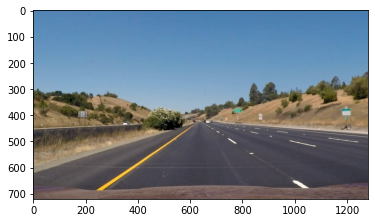

In [2]:
#reading in an image
exampleImage = mpimg.imread('test_images/straight_lines1.jpg')

#printing out some stats and plotting
print('This image is:', type(exampleImage), 'with dimensions:', exampleImage.shape)
plt.imshow(exampleImage)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [3]:
import math

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def grayscale(img):
    """Convert intial RGB image to grayscale"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

lastLeftLine = None
lastRightLine = None
def draw_lines(img, lines, color=[0, 255, 0], thickness=4, ):
    global lastLeftLine
    global lastRightLine
    leftX = []
    leftY = []
    rightX = []
    rightY = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            lineSlope = (y2 - y1)/(x2 - x1)
            if abs(lineSlope) < 0.5:
                continue
            if lineSlope < 0:
                leftX.extend([x1, x2])
                leftY.extend([y1, y2])
            else:
                rightX.extend([x1, x2])
                rightY.extend([y1, y2])
                
    if len(leftX) == 0:
        leftLine = lastLeftLine
    else:
        leftParameters = np.polyfit( leftY, leftX, 1)
        leftLine = np.poly1d(leftParameters)
        lastLeftLine = leftLine
    if len(rightX) == 0:
        rightLine = lastRightLine
    else:
        rightParameters = np.polyfit( rightY, rightX, 1)
        rightLine = np.poly1d(rightParameters)
        lastRightLine = rightLine
    
    maxY = img.shape[0]
    minY = int(img.shape[0]* 345 / 540)
    
    leftXStart = int(leftLine(maxY))
    leftXEnd = int(leftLine(minY))
    rightXStart = int(rightLine(maxY))
    rightXEnd = int(rightLine(minY))
    
    cv2.line(img, (leftXStart, maxY), (leftXEnd, minY), color, thickness)
    cv2.line(img, (rightXStart, maxY), (rightXEnd, minY), color, thickness)
    
def draw_lines_not_averaged(img, lines, color=[0, 255, 0], thickness=2):
    """
    This is an initial version of draw_lines that doesn't calculate average lines.
    This version is not currently used in the pipeline
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """  
    Returns start/end points of 2 averaged lines
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    leftX = []
    leftY = []
    rightX = []
    rightY = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            lineSlope = (y2 - y1)/(x2 - x1)
            if abs(lineSlope) < 0.5:
                continue
            if lineSlope < 0:
                leftX.extend([x1, x2])
                leftY.extend([y1, y2])
            else:
                rightX.extend([x1, x2])
                rightY.extend([y1, y2])
                

    leftParameters = np.polyfit( leftY, leftX, 1)
    leftLine = np.poly1d(leftParameters)
    rightParameters = np.polyfit( rightY, rightX, 1)
    rightLine = np.poly1d(rightParameters)

    maxY = img.shape[0]
    minY = int(img.shape[0]* 345 / 540)
    
    leftXStart = int(leftLine(maxY))
    leftXEnd = int(leftLine(minY))
    rightXStart = int(rightLine(maxY))
    rightXEnd = int(rightLine(minY))
    return minY, maxY, leftXStart, leftXEnd, rightXStart, rightXEnd

# Calibration Pipeline



In [4]:
def find_image_distortion(imgs):
    objpoints = []
    imgpoints = []

    nx = 9 #number of inside corners in x
    ny = 6 #number of inside corners in y
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    mtxList = []
    distList = []
    rvecsList = []
    tvecsList = []
    for img in imgs:
    # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
            mtxList.append(mtx)
            distList.append(dist)
            
    mtx = np.mean(mtxList, axis=0)
    dist = np.mean(distList, axis=0) 

    return mtx, dist, rvecs, tvecs
    

In [5]:
cal_images = [cv2.imread(file) for file in glob.glob("camera_cal/*.jpg")]

mtx, dist, rvecs, tvecs = find_image_distortion(cal_images)

undis_cal_images = [cv2.undistort(image, mtx, dist, None, mtx) for image in cal_images]
outNameList = map(lambda x: "out_" + x , os.listdir("camera_cal/"))
[cv2.imwrite(os.path.join("camera_cal_output/", name), image) for name, image in zip(outNameList,undis_cal_images)]

test_images = [cv2.imread(file) for file in glob.glob("test_images/*.jpg")]
test_images_changed = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in test_images]
test_images_undistorted = [cv2.undistort(testimg, mtx, dist, None, mtx) for testimg in test_images_changed]
outNameList = map(lambda x: "out_undis_" + x , os.listdir("test_images/"))
[cv2.imwrite(os.path.join("output_images/test_calibrated_output/", name), cv2.cvtColor(image, cv2.COLOR_RGB2BGR)) for name, image in zip(outNameList,test_images_undistorted)]

[True, True, True, True, True, True, True, True]

# Binary Pipeline


In [6]:
#def binary_pipeline(img, s_thresh=(120, 255), sx_thresh=(20, 100)):
def binary_pipeline(img, l_thresh=(210, 255), b_thresh=(144, 255)):
    img = np.copy(img)
    # Convert to HLS and Lab color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # take L channel from HLS and b channel from Lab
    l_channel = hls[:,:,1]  
    b_channel = lab[:,:,2]
        
    # Threshold b channel
    b_binary = np.zeros_like(l_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    
    # Threshold l channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(b_binary), b_binary, l_binary)) * 255
    return color_binary

In [7]:
test_images_binary = [ binary_pipeline(undis_image) for undis_image in test_images_undistorted]
outNameList = map(lambda x: "out_binary_" + x , os.listdir("test_images/"))
[cv2.imwrite(os.path.join("output_images/test_binary_output/", name), image) for name, image in zip(outNameList,test_images_binary)]


[True, True, True, True, True, True, True, True]

# Get Perspective Transform Matrix

In [8]:
def get_transform_matrix(images):
    
    minYL = []
    maxYL = []
    leftXStartL = []
    leftXEndL = []
    rightXStartL = []
    rightXEndL = []
    
    for image in images:
        grayMap = grayscale(image)
        smoothedImage = gaussian_blur(grayMap, 5)

        cannyMap = canny(smoothedImage, 50, 150)

        maxYRegion = image.shape[0]
        #minYRegion = int(image.shape[0]* 330 / 540)
        minYRegion = int(image.shape[0]* 345 / 540)
        leftXRegion1 = int(image.shape[1]* 110 / 960)
        #leftXRegion2 = int(image.shape[1]* 440 / 960)
        leftXRegion2 = int(image.shape[1]* 420 / 960)
        #rightXRegion1 = int(image.shape[1]* 530 / 960)
        rightXRegion1 = int(image.shape[1]* 550 / 960)
        rightXRegion2 = int(image.shape[1]* 880 / 960)
    
        vertices = np.array([[
            (leftXRegion2, minYRegion),
            (rightXRegion1, minYRegion), 
            (rightXRegion2, maxYRegion), 
            (leftXRegion1, maxYRegion)
        ]], dtype=np.int32)
        
        cannyRegionMap = region_of_interest(cannyMap, vertices)

        minY, maxY, leftXStart, leftXEnd, rightXStart, rightXEnd = hough_lines(cannyRegionMap, 1, 0.034, 15, 25, 35)
        minYL.append(minY)
        maxYL.append(maxY)
        leftXStartL.append(leftXStart)
        leftXEndL.append(leftXEnd)
        rightXStartL.append(rightXStart)
        rightXEndL.append(rightXEnd)
            
    minY = np.mean(minYL)
    maxY = np.mean(maxYL)
    leftXStart = np.mean(leftXStartL)
    leftXEnd = np.mean(leftXEndL)
    rightXStart = np.mean(rightXStartL)
    rightXEnd = np.mean(rightXEndL)
    
    src = np.float32([[leftXEnd,minY],[rightXEnd,minY],[rightXStart,maxY],[leftXStart,maxY]])
    
    imageY = images[0].shape[0]
    imageX = images[0].shape[1]
    
    minXSrc = imageX * 240 / 1300
    maxXSrc = imageX * 860 / 1300
    minYSrc = imageY * 0 / 1000
    maxYSrc = imageY * 1000 / 1000
    
    dst = np.float32([[minXSrc,minYSrc],[maxXSrc,minYSrc],[maxXSrc,maxYSrc],[minXSrc,maxYSrc]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return M, Minv

In [9]:
test_images_straight_list = [test_images_undistorted[0], test_images_undistorted[1]]
M, Minv = get_transform_matrix(test_images_straight_list)

test_images_perspective = [ 
    cv2.warpPerspective(binary_image, M, (binary_image.shape[1],binary_image.shape[0]), flags=cv2.INTER_LINEAR) for binary_image in test_images_binary
]
outNameList = map(lambda x: "out_perspective_" + x , os.listdir("test_images/"))
[cv2.imwrite(os.path.join("output_images/test_perspective_output/", name), image) for name, image in zip(outNameList,test_images_perspective)]


[True, True, True, True, True, True, True, True]

# Finding lines

In [36]:



def hist(img):
    # Load our image
    # image will load .jpg as 0-255, so normalize back to 0-1

    img_norm = img/255
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img_norm[img_norm.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

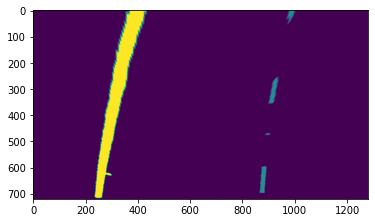

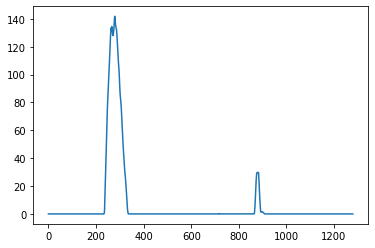

In [37]:
test_gray_perspective = [grayscale(img) for img in test_images_perspective]
plt.imshow(test_gray_perspective[4])
histograms = [hist(img) for img in test_gray_perspective]

# Visualize the resulting histogram
plt.figure()
plt.plot(histograms[4])

In [38]:
def find_lanes(binary_warped, hist):
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = int(hist.shape[0]//2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 15
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 30

    # Set height of windows - based on nwindows above and image shape
    window_height = int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    last_leftx_change = 0
    last_rightx_change = 0

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    
# Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        

        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #if you don't find min pixels, windows will have a X traslation equal to the previous one
        if len(good_left_inds) > minpix:
            last_leftx_change = int(np.mean(nonzerox[good_left_inds])) - leftx_current
            leftx_current = leftx_current + last_leftx_change
        else:
            leftx_current = leftx_current + last_leftx_change
            
        if len(good_right_inds) > minpix:
            last_rightx_change = int(np.mean(nonzerox[good_right_inds])) - rightx_current
            rightx_current = rightx_current + last_rightx_change
        else:
            rightx_current = rightx_current + last_rightx_change

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img
    
def fit_polynomial(binary_warped, hist):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lanes(binary_warped, hist)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.figure()
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img, left_fit, right_fit

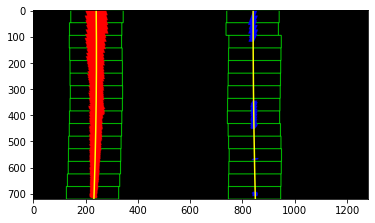

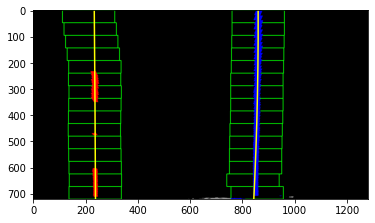

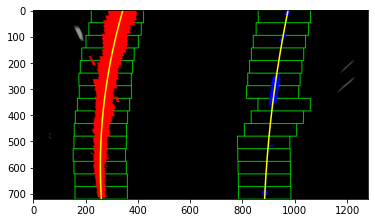

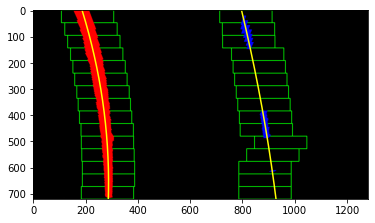

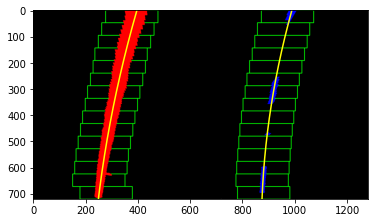

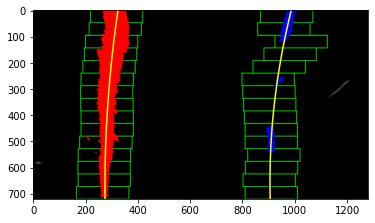

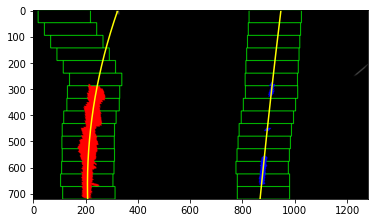

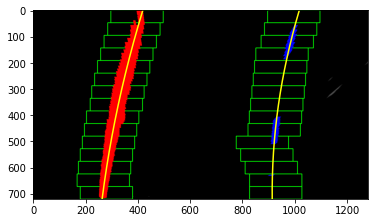

In [39]:
found_lanes, left_fits, right_fits = map(list,zip(*[fit_polynomial(img, hist) for img, hist in zip(test_gray_perspective,histograms)]))

In [40]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fit, right_fit, left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 25

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return result, left_fit, right_fit, left_fitx, right_fitx, ploty

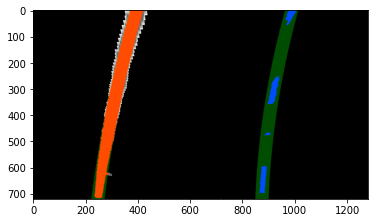

In [41]:
result, left_fit, right_fit, left_fits, right_fits, ploty = map(list,zip(*[search_around_poly(im, lf, rf) for im,lf,rf in zip(test_gray_perspective, left_fits, right_fits)]))
plt.imshow(result[4])

# Inverse Transform

In [42]:
def inv_transform (undis, warped, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undis.shape[1], undis.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undis, 1, newwarp, 0.3, 0)
    return result

In [43]:
inversed_lines = [inv_transform(u,w,lf,rf,pl) for u,w,lf,rf,pl in zip(test_images_undistorted, test_gray_perspective, left_fits, right_fits, ploty)]

# Calculate curvature

In [18]:
def measure_curvature_real(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 15/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/620 # meters per pixel in x dimension
    
    ##### calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

def paint_curvature(image, curvature1, curvature2):
    img = np.copy(image)
    font = cv2.FONT_HERSHEY_SIMPLEX

    cv2.putText(img, 'Left Lane Curvature: {:.0f} m'.format(curvature1), (10,40), font, 1,(255,255,255),2)
    cv2.putText(img, 'Left Lane Curvature: {:.0f} m'.format(curvature2), (10,100), font, 1,(255,255,255),2)
    return img

In [19]:
indxvar = 5
left_curvetest, right_curvetest = measure_curvature_real(ploty[indxvar], left_fit[indxvar], right_fit[indxvar])
image_w_curvature = paint_curvature(inversed_lines[indxvar],left_curvetest, right_curvetest)

719.0


# Calculate offset

In [20]:
def measure_and_paint_offset_real(image, left_fits, right_fits):
    img = np.copy(image)
    image_center = image.shape[1]/2
    car_center = np.mean([left_fits[-1],right_fits[-1]])
    
    xm_per_pix = 3.7/620 # meters per pixel in x dimension
    offset = (image_center - car_center) * xm_per_pix
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Offset: {:.2f} m'.format(offset), (10,150), font, 1,(255,255,255),2)
    return img

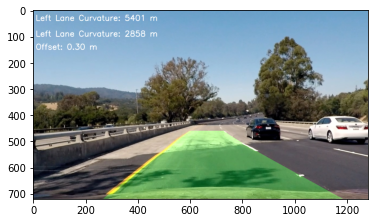

In [21]:
image_w_offset = measure_and_paint_offset_real(image_w_curvature, left_fits[indxvar], right_fits[indxvar])
plt.imshow(image_w_offset)

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
counter = 0
v_left_fit = None
v_right_fit = None
v_ploty = None


In [23]:
def process_image (img):
    global counter
    global mtx
    global dist
    global M
    global Minv
    global v_left_fit
    global v_right_fit
    global v_ploty
    global v_left_fitx
    global v_right_fitx
    
    undis_image = cv2.undistort(img, mtx, dist, None, mtx)
    binary_image = binary_pipeline(undis_image)
    perspective_image = cv2.warpPerspective(binary_image, M, (binary_image.shape[1],binary_image.shape[0]), flags=cv2.INTER_LINEAR)
    perspective_gray = grayscale(perspective_image)
    
    if counter < 1:
        counter = 1
        histogram = hist(perspective_gray)
        found_lanes, v_left_fit, v_right_fit = fit_polynomial(perspective_gray, histogram)
        non_used_var, v_left_fit, v_right_fit, v_left_fitx, v_right_fitx, v_ploty = search_around_poly(perspective_gray, v_left_fit, v_right_fit) 
    else:
        non_used_var, v_left_fit, v_right_fit, v_left_fitx, v_right_fitx, v_ploty = search_around_poly(perspective_gray, v_left_fit, v_right_fit)
    
    inversed = inv_transform(undis_image,perspective_gray,v_left_fitx,v_right_fitx,v_ploty)
    left_meters, right_meters = measure_curvature_real(v_ploty, v_left_fit, v_right_fit)
    img_printed_curv = paint_curvature(inversed, left_meters, right_meters)
    img_printed_off = measure_and_paint_offset_real(img_printed_curv, v_left_fitx, v_right_fitx)

    return img_printed_off


t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

719.0
Moviepy - Building video videos_output/video1_output.mp4.
Moviepy - Writing video videos_output/video1_output.mp4

719.0


t:   0%|▏                                                                   | 3/1260 [00:00<06:24,  3.27it/s, now=None]

719.0
719.0

t:   0%|▏                                                                   | 4/1260 [00:01<05:33,  3.76it/s, now=None]

t:   0%|▎                                                                   | 5/1260 [00:01<05:09,  4.06it/s, now=None]

719.0


t:   0%|▎                                                                   | 6/1260 [00:01<04:52,  4.29it/s, now=None]

719.0


t:   1%|▍                                                                   | 7/1260 [00:01<04:59,  4.19it/s, now=None]

719.0


t:   1%|▍                                                                   | 8/1260 [00:02<04:53,  4.27it/s, now=None]

719.0


t:   1%|▍                                                                   | 9/1260 [00:02<04:53,  4.26it/s, now=None]

719.0
719.0

t:   1%|▌                                                                  | 10/1260 [00:02<04:43,  4.41it/s, now=None]

t:   1%|▌                                                                  | 11/1260 [00:02<04:51,  4.29it/s, now=None]

719.0


t:   1%|▋                                                                  | 12/1260 [00:02<04:49,  4.31it/s, now=None]

719.0


t:   1%|▋                                                                  | 13/1260 [00:03<04:41,  4.43it/s, now=None]

719.0


t:   1%|▋                                                                  | 14/1260 [00:03<04:34,  4.53it/s, now=None]

719.0
719.0

t:   1%|▊                                                                  | 15/1260 [00:03<04:30,  4.60it/s, now=None]

t:   1%|▊                                                                  | 16/1260 [00:03<04:29,  4.62it/s, now=None]

719.0
719.0

t:   1%|▉                                                                  | 17/1260 [00:04<04:25,  4.68it/s, now=None]

t:   1%|▉                                                                  | 18/1260 [00:04<04:33,  4.53it/s, now=None]

719.0
719.0

t:   2%|█                                                                  | 19/1260 [00:04<04:28,  4.62it/s, now=None]


719.0

t:   2%|█                                                                  | 20/1260 [00:04<04:25,  4.66it/s, now=None]

t:   2%|█                                                                  | 21/1260 [00:04<04:26,  4.65it/s, now=None]

719.0


t:   2%|█▏                                                                 | 22/1260 [00:05<04:29,  4.60it/s, now=None]

719.0
719.0

t:   2%|█▏                                                                 | 23/1260 [00:05<04:23,  4.69it/s, now=None]


719.0

t:   2%|█▎                                                                 | 24/1260 [00:05<04:19,  4.75it/s, now=None]


719.0

t:   2%|█▎                                                                 | 25/1260 [00:05<04:20,  4.74it/s, now=None]


719.0

t:   2%|█▍                                                                 | 26/1260 [00:05<04:17,  4.80it/s, now=None]

t:   2%|█▍                                                                 | 27/1260 [00:06<04:25,  4.64it/s, now=None]

719.0


t:   2%|█▍                                                                 | 28/1260 [00:06<04:22,  4.69it/s, now=None]

719.0
719.0

t:   2%|█▌                                                                 | 29/1260 [00:06<04:20,  4.72it/s, now=None]


719.0

t:   2%|█▌                                                                 | 30/1260 [00:06<04:17,  4.77it/s, now=None]

t:   2%|█▋                                                                 | 31/1260 [00:07<04:20,  4.72it/s, now=None]

719.0


t:   3%|█▋                                                                 | 32/1260 [00:07<04:22,  4.68it/s, now=None]

719.0
719.0

t:   3%|█▊                                                                 | 33/1260 [00:07<04:15,  4.80it/s, now=None]


719.0

t:   3%|█▊                                                                 | 34/1260 [00:07<04:11,  4.88it/s, now=None]


719.0

t:   3%|█▊                                                                 | 35/1260 [00:07<04:12,  4.86it/s, now=None]

t:   3%|█▉                                                                 | 36/1260 [00:08<04:16,  4.77it/s, now=None]

719.0


t:   3%|█▉                                                                 | 37/1260 [00:08<04:15,  4.78it/s, now=None]

719.0
719.0

t:   3%|██                                                                 | 38/1260 [00:08<04:05,  4.97it/s, now=None]


719.0

t:   3%|██                                                                 | 39/1260 [00:08<04:02,  5.04it/s, now=None]

t:   3%|██▏                                                                | 40/1260 [00:08<04:12,  4.84it/s, now=None]

719.0
719.0

t:   3%|██▏                                                                | 41/1260 [00:09<04:08,  4.91it/s, now=None]


719.0

t:   3%|██▏                                                                | 42/1260 [00:09<04:08,  4.90it/s, now=None]

t:   3%|██▎                                                                | 43/1260 [00:09<04:19,  4.68it/s, now=None]

719.0


t:   3%|██▎                                                                | 44/1260 [00:09<04:25,  4.57it/s, now=None]

719.0


t:   4%|██▍                                                                | 45/1260 [00:09<04:29,  4.50it/s, now=None]

719.0


t:   4%|██▍                                                                | 46/1260 [00:10<04:30,  4.48it/s, now=None]

719.0


t:   4%|██▍                                                                | 47/1260 [00:10<04:22,  4.61it/s, now=None]

719.0


t:   4%|██▌                                                                | 48/1260 [00:10<04:27,  4.52it/s, now=None]

719.0


t:   4%|██▌                                                                | 49/1260 [00:10<04:26,  4.54it/s, now=None]

719.0


t:   4%|██▋                                                                | 50/1260 [00:11<04:32,  4.45it/s, now=None]

719.0


t:   4%|██▋                                                                | 51/1260 [00:11<04:26,  4.54it/s, now=None]

719.0
719.0

t:   4%|██▊                                                                | 52/1260 [00:11<04:21,  4.62it/s, now=None]


719.0

t:   4%|██▊                                                                | 53/1260 [00:11<04:18,  4.66it/s, now=None]

t:   4%|██▊                                                                | 54/1260 [00:11<04:15,  4.72it/s, now=None]

719.0


t:   4%|██▉                                                                | 55/1260 [00:12<04:08,  4.85it/s, now=None]

719.0
719.0

t:   4%|██▉                                                                | 56/1260 [00:12<04:03,  4.95it/s, now=None]

t:   5%|███                                                                | 57/1260 [00:12<04:05,  4.90it/s, now=None]

719.0
719.0

t:   5%|███                                                                | 58/1260 [00:12<04:02,  4.95it/s, now=None]


719.0

t:   5%|███▏                                                               | 59/1260 [00:12<03:58,  5.03it/s, now=None]


719.0

t:   5%|███▏                                                               | 60/1260 [00:13<03:59,  5.02it/s, now=None]

t:   5%|███▏                                                               | 61/1260 [00:13<04:03,  4.92it/s, now=None]

719.0
719.0

t:   5%|███▎                                                               | 62/1260 [00:13<04:05,  4.87it/s, now=None]

t:   5%|███▎                                                               | 63/1260 [00:13<04:04,  4.89it/s, now=None]

719.0


t:   5%|███▍                                                               | 64/1260 [00:13<04:03,  4.92it/s, now=None]

719.0


t:   5%|███▍                                                               | 65/1260 [00:14<04:06,  4.86it/s, now=None]

719.0
719.0

t:   5%|███▌                                                               | 66/1260 [00:14<04:04,  4.89it/s, now=None]

t:   5%|███▌                                                               | 67/1260 [00:14<04:06,  4.84it/s, now=None]

719.0
719.0

t:   5%|███▌                                                               | 68/1260 [00:14<04:05,  4.85it/s, now=None]

t:   5%|███▋                                                               | 69/1260 [00:14<04:05,  4.84it/s, now=None]

719.0


t:   6%|███▋                                                               | 70/1260 [00:15<04:13,  4.69it/s, now=None]

719.0


t:   6%|███▊                                                               | 71/1260 [00:15<04:11,  4.74it/s, now=None]

719.0
719.0

t:   6%|███▊                                                               | 72/1260 [00:15<04:10,  4.75it/s, now=None]

t:   6%|███▉                                                               | 73/1260 [00:15<04:13,  4.68it/s, now=None]

719.0
719.0

t:   6%|███▉                                                               | 74/1260 [00:16<04:09,  4.75it/s, now=None]

t:   6%|███▉                                                               | 75/1260 [00:16<04:08,  4.77it/s, now=None]

719.0
719.0

t:   6%|████                                                               | 76/1260 [00:16<04:05,  4.82it/s, now=None]


719.0

t:   6%|████                                                               | 77/1260 [00:16<03:59,  4.94it/s, now=None]


719.0

t:   6%|████▏                                                              | 78/1260 [00:16<03:54,  5.03it/s, now=None]


719.0

t:   6%|████▏                                                              | 79/1260 [00:17<03:55,  5.02it/s, now=None]


719.0


t:   6%|████▎                                                              | 81/1260 [00:17<03:50,  5.12it/s, now=None]

719.0


t:   7%|████▎                                                              | 82/1260 [00:17<03:51,  5.08it/s, now=None]

719.0


t:   7%|████▍                                                              | 83/1260 [00:17<03:57,  4.95it/s, now=None]

719.0
719.0

t:   7%|████▍                                                              | 84/1260 [00:18<03:54,  5.01it/s, now=None]


719.0

t:   7%|████▌                                                              | 85/1260 [00:18<03:54,  5.02it/s, now=None]


719.0

t:   7%|████▌                                                              | 86/1260 [00:18<03:55,  5.00it/s, now=None]


719.0

t:   7%|████▋                                                              | 87/1260 [00:18<03:49,  5.11it/s, now=None]

t:   7%|████▋                                                              | 88/1260 [00:18<03:50,  5.08it/s, now=None]

719.0
719.0

t:   7%|████▋                                                              | 89/1260 [00:18<03:49,  5.10it/s, now=None]


719.0

t:   7%|████▊                                                              | 90/1260 [00:19<03:47,  5.15it/s, now=None]


719.0

t:   7%|████▊                                                              | 91/1260 [00:19<03:52,  5.03it/s, now=None]


719.0

t:   7%|████▉                                                              | 92/1260 [00:19<03:52,  5.03it/s, now=None]


719.0

t:   7%|████▉                                                              | 93/1260 [00:19<03:52,  5.01it/s, now=None]


719.0

t:   7%|████▉                                                              | 94/1260 [00:19<03:57,  4.90it/s, now=None]

t:   8%|█████                                                              | 95/1260 [00:20<04:00,  4.84it/s, now=None]

719.0
719.0

t:   8%|█████                                                              | 96/1260 [00:20<04:00,  4.84it/s, now=None]

t:   8%|█████▏                                                             | 97/1260 [00:20<03:59,  4.86it/s, now=None]

719.0
719.0

t:   8%|█████▏                                                             | 98/1260 [00:20<03:58,  4.87it/s, now=None]

t:   8%|█████▎                                                             | 99/1260 [00:21<04:01,  4.80it/s, now=None]

719.0
719.0

t:   8%|█████▏                                                            | 100/1260 [00:21<03:59,  4.85it/s, now=None]

t:   8%|█████▎                                                            | 101/1260 [00:21<04:00,  4.83it/s, now=None]

719.0
719.0

t:   8%|█████▎                                                            | 102/1260 [00:21<03:55,  4.91it/s, now=None]

t:   8%|█████▍                                                            | 103/1260 [00:21<03:55,  4.91it/s, now=None]

719.0
719.0

t:   8%|█████▍                                                            | 104/1260 [00:22<03:55,  4.92it/s, now=None]

t:   8%|█████▌                                                            | 105/1260 [00:22<04:03,  4.75it/s, now=None]

719.0


t:   8%|█████▌                                                            | 106/1260 [00:22<04:15,  4.51it/s, now=None]

719.0
719.0

t:   8%|█████▌                                                            | 107/1260 [00:22<04:07,  4.65it/s, now=None]


719.0

t:   9%|█████▋                                                            | 108/1260 [00:22<04:03,  4.74it/s, now=None]

t:   9%|█████▋                                                            | 109/1260 [00:23<04:20,  4.42it/s, now=None]

719.0
719.0

t:   9%|█████▊                                                            | 110/1260 [00:23<04:12,  4.56it/s, now=None]


719.0

t:   9%|█████▊                                                            | 111/1260 [00:23<04:07,  4.65it/s, now=None]


719.0

t:   9%|█████▊                                                            | 112/1260 [00:23<04:00,  4.78it/s, now=None]


719.0

t:   9%|█████▉                                                            | 113/1260 [00:23<03:57,  4.83it/s, now=None]


719.0

t:   9%|█████▉                                                            | 114/1260 [00:24<03:55,  4.86it/s, now=None]

t:   9%|██████                                                            | 115/1260 [00:24<03:57,  4.82it/s, now=None]

719.0
719.0

t:   9%|██████                                                            | 116/1260 [00:24<03:54,  4.87it/s, now=None]

t:   9%|██████▏                                                           | 117/1260 [00:24<03:55,  4.85it/s, now=None]

719.0


t:   9%|██████▏                                                           | 118/1260 [00:25<04:06,  4.63it/s, now=None]

719.0


t:   9%|██████▏                                                           | 119/1260 [00:25<04:12,  4.53it/s, now=None]

719.0


t:  10%|██████▎                                                           | 120/1260 [00:25<04:23,  4.33it/s, now=None]

719.0


t:  10%|██████▎                                                           | 121/1260 [00:25<04:18,  4.40it/s, now=None]

719.0
719.0

t:  10%|██████▍                                                           | 122/1260 [00:25<04:10,  4.55it/s, now=None]

t:  10%|██████▍                                                           | 123/1260 [00:26<04:21,  4.34it/s, now=None]

719.0


t:  10%|██████▍                                                           | 124/1260 [00:26<04:16,  4.43it/s, now=None]

719.0
719.0

t:  10%|██████▌                                                           | 125/1260 [00:26<04:07,  4.59it/s, now=None]


719.0

t:  10%|██████▌                                                           | 126/1260 [00:26<03:58,  4.75it/s, now=None]


719.0

t:  10%|██████▋                                                           | 127/1260 [00:27<03:56,  4.80it/s, now=None]

t:  10%|██████▋                                                           | 128/1260 [00:27<03:56,  4.78it/s, now=None]

719.0


t:  10%|██████▊                                                           | 129/1260 [00:27<03:58,  4.75it/s, now=None]

719.0
719.0

t:  10%|██████▊                                                           | 130/1260 [00:27<03:53,  4.84it/s, now=None]

t:  10%|██████▊                                                           | 131/1260 [00:27<03:52,  4.86it/s, now=None]

719.0
719.0

t:  10%|██████▉                                                           | 132/1260 [00:28<03:49,  4.91it/s, now=None]


719.0

t:  11%|██████▉                                                           | 133/1260 [00:28<03:49,  4.91it/s, now=None]


719.0

t:  11%|███████                                                           | 134/1260 [00:28<03:47,  4.95it/s, now=None]


719.0

t:  11%|███████                                                           | 135/1260 [00:28<03:42,  5.05it/s, now=None]


719.0

t:  11%|███████                                                           | 136/1260 [00:28<03:41,  5.07it/s, now=None]

t:  11%|███████▏                                                          | 137/1260 [00:29<03:51,  4.84it/s, now=None]

719.0
719.0

t:  11%|███████▏                                                          | 138/1260 [00:29<03:48,  4.92it/s, now=None]


719.0

t:  11%|███████▎                                                          | 139/1260 [00:29<03:46,  4.96it/s, now=None]


719.0

t:  11%|███████▎                                                          | 140/1260 [00:29<03:50,  4.87it/s, now=None]

t:  11%|███████▍                                                          | 141/1260 [00:29<03:47,  4.92it/s, now=None]

719.0
719.0

t:  11%|███████▍                                                          | 142/1260 [00:30<03:44,  4.97it/s, now=None]


719.0

t:  11%|███████▍                                                          | 143/1260 [00:30<03:47,  4.91it/s, now=None]


719.0

t:  11%|███████▌                                                          | 144/1260 [00:30<03:46,  4.93it/s, now=None]


719.0

t:  12%|███████▌                                                          | 145/1260 [00:30<03:46,  4.93it/s, now=None]


719.0

t:  12%|███████▋                                                          | 146/1260 [00:30<03:42,  5.01it/s, now=None]


719.0

t:  12%|███████▋                                                          | 147/1260 [00:31<03:41,  5.02it/s, now=None]


719.0

t:  12%|███████▊                                                          | 148/1260 [00:31<03:40,  5.04it/s, now=None]


719.0

t:  12%|███████▊                                                          | 149/1260 [00:31<03:41,  5.02it/s, now=None]

t:  12%|███████▊                                                          | 150/1260 [00:31<03:42,  5.00it/s, now=None]

719.0
719.0

t:  12%|███████▉                                                          | 151/1260 [00:31<03:41,  5.01it/s, now=None]


719.0

t:  12%|███████▉                                                          | 152/1260 [00:32<03:39,  5.05it/s, now=None]

t:  12%|████████                                                          | 153/1260 [00:32<03:41,  4.99it/s, now=None]

719.0
719.0

t:  12%|████████                                                          | 154/1260 [00:32<03:38,  5.07it/s, now=None]

t:  12%|████████                                                          | 155/1260 [00:32<03:38,  5.05it/s, now=None]

719.0
719.0

t:  12%|████████▏                                                         | 156/1260 [00:32<03:38,  5.05it/s, now=None]

t:  12%|████████▏                                                         | 157/1260 [00:33<03:38,  5.04it/s, now=None]

719.0
719.0

t:  13%|████████▎                                                         | 158/1260 [00:33<03:38,  5.04it/s, now=None]

t:  13%|████████▎                                                         | 159/1260 [00:33<03:37,  5.07it/s, now=None]

719.0
719.0

t:  13%|████████▍                                                         | 160/1260 [00:33<03:36,  5.08it/s, now=None]

t:  13%|████████▍                                                         | 161/1260 [00:33<03:48,  4.81it/s, now=None]

719.0


t:  13%|████████▍                                                         | 162/1260 [00:34<03:42,  4.93it/s, now=None]

719.0


t:  13%|████████▌                                                         | 163/1260 [00:34<03:41,  4.95it/s, now=None]

719.0
719.0

t:  13%|████████▌                                                         | 164/1260 [00:34<03:37,  5.04it/s, now=None]


719.0

t:  13%|████████▋                                                         | 165/1260 [00:34<03:36,  5.06it/s, now=None]

t:  13%|████████▋                                                         | 166/1260 [00:34<03:41,  4.95it/s, now=None]

719.0
719.0

t:  13%|████████▋                                                         | 167/1260 [00:35<03:44,  4.86it/s, now=None]

t:  13%|████████▊                                                         | 168/1260 [00:35<03:43,  4.88it/s, now=None]

719.0
719.0

t:  13%|████████▊                                                         | 169/1260 [00:35<03:42,  4.90it/s, now=None]

t:  13%|████████▉                                                         | 170/1260 [00:35<03:41,  4.93it/s, now=None]

719.0


t:  14%|████████▉                                                         | 171/1260 [00:35<03:39,  4.95it/s, now=None]

719.0
719.0

t:  14%|█████████                                                         | 172/1260 [00:36<03:41,  4.91it/s, now=None]


719.0

t:  14%|█████████                                                         | 173/1260 [00:36<03:38,  4.97it/s, now=None]

t:  14%|█████████                                                         | 174/1260 [00:36<03:40,  4.93it/s, now=None]

719.0


t:  14%|█████████▏                                                        | 175/1260 [00:36<03:34,  5.05it/s, now=None]

719.0
719.0

t:  14%|█████████▏                                                        | 176/1260 [00:36<03:35,  5.03it/s, now=None]

t:  14%|█████████▎                                                        | 177/1260 [00:37<03:41,  4.89it/s, now=None]

719.0
719.0

t:  14%|█████████▎                                                        | 178/1260 [00:37<03:36,  5.00it/s, now=None]


719.0

t:  14%|█████████▍                                                        | 179/1260 [00:37<03:35,  5.01it/s, now=None]


719.0

t:  14%|█████████▍                                                        | 180/1260 [00:37<03:36,  4.98it/s, now=None]


719.0


t:  14%|█████████▌                                                        | 182/1260 [00:38<03:39,  4.91it/s, now=None]

719.0
719.0

t:  15%|█████████▌                                                        | 183/1260 [00:38<03:40,  4.89it/s, now=None]


719.0

t:  15%|█████████▋                                                        | 184/1260 [00:38<03:37,  4.95it/s, now=None]

t:  15%|█████████▋                                                        | 185/1260 [00:38<03:36,  4.96it/s, now=None]

719.0


t:  15%|█████████▋                                                        | 186/1260 [00:38<03:41,  4.84it/s, now=None]

719.0
719.0


t:  15%|█████████▊                                                        | 187/1260 [00:39<03:37,  4.92it/s, now=None]

719.0

t:  15%|█████████▊                                                        | 188/1260 [00:39<03:39,  4.89it/s, now=None]


719.0

t:  15%|█████████▉                                                        | 189/1260 [00:39<03:38,  4.91it/s, now=None]


719.0


t:  15%|██████████                                                        | 191/1260 [00:39<03:42,  4.81it/s, now=None]

719.0
719.0

t:  15%|██████████                                                        | 192/1260 [00:40<03:38,  4.89it/s, now=None]

t:  15%|██████████                                                        | 193/1260 [00:40<03:37,  4.90it/s, now=None]

719.0


t:  15%|██████████▏                                                       | 194/1260 [00:40<04:14,  4.19it/s, now=None]

719.0


t:  15%|██████████▏                                                       | 195/1260 [00:40<04:01,  4.40it/s, now=None]

719.0


t:  16%|██████████▎                                                       | 196/1260 [00:41<03:51,  4.59it/s, now=None]

719.0
719.0


t:  16%|██████████▎                                                       | 198/1260 [00:41<03:44,  4.72it/s, now=None]

719.0


t:  16%|██████████▍                                                       | 199/1260 [00:41<03:39,  4.83it/s, now=None]

719.0
719.0


t:  16%|██████████▌                                                       | 201/1260 [00:42<03:34,  4.94it/s, now=None]

719.0
719.0


t:  16%|██████████▋                                                       | 203/1260 [00:42<03:30,  5.02it/s, now=None]

719.0
719.0

t:  16%|██████████▋                                                       | 204/1260 [00:42<03:30,  5.02it/s, now=None]


719.0

t:  16%|██████████▋                                                       | 205/1260 [00:42<03:28,  5.06it/s, now=None]

t:  16%|██████████▊                                                       | 206/1260 [00:43<03:35,  4.89it/s, now=None]

719.0


t:  16%|██████████▊                                                       | 207/1260 [00:43<03:36,  4.86it/s, now=None]

719.0


t:  17%|██████████▉                                                       | 208/1260 [00:43<03:31,  4.96it/s, now=None]

719.0
719.0

t:  17%|██████████▉                                                       | 209/1260 [00:43<03:29,  5.02it/s, now=None]


719.0

t:  17%|███████████                                                       | 210/1260 [00:43<03:26,  5.08it/s, now=None]


719.0

t:  17%|███████████                                                       | 211/1260 [00:44<03:23,  5.14it/s, now=None]


719.0

t:  17%|███████████                                                       | 212/1260 [00:44<03:21,  5.20it/s, now=None]

t:  17%|███████████▏                                                      | 213/1260 [00:44<03:25,  5.11it/s, now=None]

719.0
719.0

t:  17%|███████████▏                                                      | 214/1260 [00:44<03:27,  5.05it/s, now=None]

t:  17%|███████████▎                                                      | 215/1260 [00:44<03:26,  5.06it/s, now=None]

719.0
719.0

t:  17%|███████████▎                                                      | 216/1260 [00:45<03:24,  5.10it/s, now=None]

t:  17%|███████████▎                                                      | 217/1260 [00:45<03:28,  5.01it/s, now=None]

719.0


t:  17%|███████████▍                                                      | 218/1260 [00:45<03:25,  5.07it/s, now=None]

719.0
719.0

t:  17%|███████████▍                                                      | 219/1260 [00:45<03:26,  5.03it/s, now=None]

t:  17%|███████████▌                                                      | 220/1260 [00:45<03:28,  4.98it/s, now=None]

719.0


t:  18%|███████████▌                                                      | 221/1260 [00:46<03:32,  4.88it/s, now=None]

719.0
719.0

t:  18%|███████████▋                                                      | 222/1260 [00:46<03:29,  4.95it/s, now=None]


719.0

t:  18%|███████████▋                                                      | 223/1260 [00:46<03:27,  5.00it/s, now=None]


719.0

t:  18%|███████████▋                                                      | 224/1260 [00:46<03:24,  5.07it/s, now=None]

t:  18%|███████████▊                                                      | 225/1260 [00:46<03:25,  5.02it/s, now=None]

719.0


t:  18%|███████████▊                                                      | 226/1260 [00:47<03:24,  5.06it/s, now=None]

719.0


t:  18%|███████████▉                                                      | 227/1260 [00:47<03:29,  4.93it/s, now=None]

719.0


t:  18%|███████████▉                                                      | 228/1260 [00:47<03:27,  4.97it/s, now=None]

719.0


t:  18%|███████████▉                                                      | 229/1260 [00:47<03:29,  4.93it/s, now=None]

719.0
719.0

t:  18%|████████████                                                      | 230/1260 [00:47<03:24,  5.02it/s, now=None]


719.0

t:  18%|████████████                                                      | 231/1260 [00:48<03:24,  5.02it/s, now=None]

t:  18%|████████████▏                                                     | 232/1260 [00:48<03:32,  4.83it/s, now=None]

719.0


t:  18%|████████████▏                                                     | 233/1260 [00:48<03:38,  4.71it/s, now=None]

719.0


t:  19%|████████████▎                                                     | 234/1260 [00:48<03:42,  4.61it/s, now=None]

719.0


t:  19%|████████████▎                                                     | 235/1260 [00:48<03:43,  4.59it/s, now=None]

719.0


t:  19%|████████████▎                                                     | 236/1260 [00:49<03:50,  4.44it/s, now=None]

719.0


t:  19%|████████████▍                                                     | 237/1260 [00:49<03:51,  4.42it/s, now=None]

719.0


t:  19%|████████████▍                                                     | 238/1260 [00:49<03:45,  4.54it/s, now=None]

719.0


t:  19%|████████████▌                                                     | 239/1260 [00:49<03:57,  4.31it/s, now=None]

719.0


t:  19%|████████████▌                                                     | 240/1260 [00:50<03:54,  4.34it/s, now=None]

719.0


t:  19%|████████████▌                                                     | 241/1260 [00:50<04:05,  4.14it/s, now=None]

719.0
719.0

t:  19%|████████████▋                                                     | 242/1260 [00:50<03:55,  4.32it/s, now=None]

t:  19%|████████████▋                                                     | 243/1260 [00:50<03:56,  4.30it/s, now=None]

719.0


t:  19%|████████████▊                                                     | 244/1260 [00:51<03:58,  4.27it/s, now=None]

719.0


t:  19%|████████████▊                                                     | 245/1260 [00:51<03:57,  4.27it/s, now=None]

719.0


t:  20%|████████████▉                                                     | 246/1260 [00:51<04:20,  3.90it/s, now=None]

719.0


t:  20%|████████████▉                                                     | 247/1260 [00:51<04:04,  4.14it/s, now=None]

719.0
719.0

t:  20%|████████████▉                                                     | 248/1260 [00:51<03:53,  4.34it/s, now=None]

t:  20%|█████████████                                                     | 249/1260 [00:52<03:57,  4.25it/s, now=None]

719.0


t:  20%|█████████████                                                     | 250/1260 [00:52<03:50,  4.39it/s, now=None]

719.0
719.0

t:  20%|█████████████▏                                                    | 251/1260 [00:52<03:43,  4.52it/s, now=None]

t:  20%|█████████████▏                                                    | 252/1260 [00:52<03:37,  4.62it/s, now=None]

719.0


t:  20%|█████████████▎                                                    | 253/1260 [00:53<03:40,  4.57it/s, now=None]

719.0
719.0

t:  20%|█████████████▎                                                    | 254/1260 [00:53<03:35,  4.67it/s, now=None]


719.0

t:  20%|█████████████▎                                                    | 255/1260 [00:53<03:33,  4.71it/s, now=None]

t:  20%|█████████████▍                                                    | 256/1260 [00:53<03:33,  4.71it/s, now=None]

719.0


t:  20%|█████████████▍                                                    | 257/1260 [00:53<03:31,  4.74it/s, now=None]

719.0


t:  20%|█████████████▌                                                    | 258/1260 [00:54<03:30,  4.77it/s, now=None]

719.0


t:  21%|█████████████▌                                                    | 259/1260 [00:54<03:28,  4.79it/s, now=None]

719.0


t:  21%|█████████████▌                                                    | 260/1260 [00:54<03:35,  4.64it/s, now=None]

719.0
719.0

t:  21%|█████████████▋                                                    | 261/1260 [00:54<03:34,  4.65it/s, now=None]

t:  21%|█████████████▋                                                    | 262/1260 [00:54<03:33,  4.67it/s, now=None]

719.0


t:  21%|█████████████▊                                                    | 263/1260 [00:55<03:34,  4.64it/s, now=None]

719.0


t:  21%|█████████████▊                                                    | 264/1260 [00:55<03:41,  4.50it/s, now=None]

719.0


t:  21%|█████████████▉                                                    | 265/1260 [00:55<03:52,  4.28it/s, now=None]

719.0


t:  21%|█████████████▉                                                    | 266/1260 [00:55<03:46,  4.39it/s, now=None]

719.0


t:  21%|█████████████▉                                                    | 267/1260 [00:56<03:44,  4.42it/s, now=None]

719.0
719.0

t:  21%|██████████████                                                    | 268/1260 [00:56<03:36,  4.58it/s, now=None]


719.0

t:  21%|██████████████                                                    | 269/1260 [00:56<03:32,  4.66it/s, now=None]


719.0

t:  21%|██████████████▏                                                   | 270/1260 [00:56<03:30,  4.70it/s, now=None]


719.0

t:  22%|██████████████▏                                                   | 271/1260 [00:56<03:27,  4.77it/s, now=None]


719.0

t:  22%|██████████████▏                                                   | 272/1260 [00:57<03:27,  4.77it/s, now=None]

t:  22%|██████████████▎                                                   | 273/1260 [00:57<03:28,  4.73it/s, now=None]

719.0
719.0

t:  22%|██████████████▎                                                   | 274/1260 [00:57<03:26,  4.78it/s, now=None]

t:  22%|██████████████▍                                                   | 275/1260 [00:57<03:22,  4.87it/s, now=None]

719.0
719.0

t:  22%|██████████████▍                                                   | 276/1260 [00:57<03:20,  4.91it/s, now=None]


719.0

t:  22%|██████████████▌                                                   | 277/1260 [00:58<03:18,  4.95it/s, now=None]


719.0

t:  22%|██████████████▌                                                   | 278/1260 [00:58<03:19,  4.93it/s, now=None]

t:  22%|██████████████▌                                                   | 279/1260 [00:58<03:18,  4.93it/s, now=None]

719.0


t:  22%|██████████████▋                                                   | 280/1260 [00:58<03:21,  4.86it/s, now=None]

719.0
719.0

t:  22%|██████████████▋                                                   | 281/1260 [00:59<03:18,  4.93it/s, now=None]

t:  22%|██████████████▊                                                   | 282/1260 [00:59<03:17,  4.96it/s, now=None]

719.0
719.0

t:  22%|██████████████▊                                                   | 283/1260 [00:59<03:16,  4.97it/s, now=None]


719.0

t:  23%|██████████████▉                                                   | 284/1260 [00:59<03:17,  4.95it/s, now=None]


719.0

t:  23%|██████████████▉                                                   | 285/1260 [00:59<03:18,  4.91it/s, now=None]

t:  23%|██████████████▉                                                   | 286/1260 [01:00<03:17,  4.94it/s, now=None]

719.0
719.0

t:  23%|███████████████                                                   | 287/1260 [01:00<03:18,  4.91it/s, now=None]

t:  23%|███████████████                                                   | 288/1260 [01:00<03:20,  4.86it/s, now=None]

719.0


t:  23%|███████████████▏                                                  | 289/1260 [01:00<03:19,  4.88it/s, now=None]

719.0
719.0


t:  23%|███████████████▏                                                  | 291/1260 [01:01<03:12,  5.02it/s, now=None]

719.0
719.0

t:  23%|███████████████▎                                                  | 292/1260 [01:01<03:16,  4.93it/s, now=None]

t:  23%|███████████████▎                                                  | 293/1260 [01:01<03:16,  4.92it/s, now=None]

719.0


t:  23%|███████████████▍                                                  | 294/1260 [01:01<03:18,  4.86it/s, now=None]

719.0


t:  23%|███████████████▍                                                  | 295/1260 [01:01<03:16,  4.90it/s, now=None]

719.0
719.0

t:  23%|███████████████▌                                                  | 296/1260 [01:02<03:15,  4.93it/s, now=None]


719.0

t:  24%|███████████████▌                                                  | 297/1260 [01:02<03:15,  4.92it/s, now=None]


719.0

t:  24%|███████████████▌                                                  | 298/1260 [01:02<03:09,  5.07it/s, now=None]

t:  24%|███████████████▋                                                  | 299/1260 [01:02<03:17,  4.86it/s, now=None]

719.0
719.0

t:  24%|███████████████▋                                                  | 300/1260 [01:02<03:15,  4.92it/s, now=None]


719.0

t:  24%|███████████████▊                                                  | 301/1260 [01:03<03:16,  4.88it/s, now=None]


719.0


t:  24%|███████████████▊                                                  | 303/1260 [01:03<03:15,  4.89it/s, now=None]

719.0


t:  24%|███████████████▉                                                  | 304/1260 [01:03<03:21,  4.76it/s, now=None]

719.0
719.0

t:  24%|███████████████▉                                                  | 305/1260 [01:03<03:21,  4.75it/s, now=None]

t:  24%|████████████████                                                  | 306/1260 [01:04<03:27,  4.59it/s, now=None]

719.0


t:  24%|████████████████                                                  | 307/1260 [01:04<03:41,  4.30it/s, now=None]

719.0


t:  24%|████████████████▏                                                 | 308/1260 [01:04<03:37,  4.37it/s, now=None]

719.0


t:  25%|████████████████▏                                                 | 309/1260 [01:04<03:38,  4.36it/s, now=None]

719.0
719.0

t:  25%|████████████████▏                                                 | 310/1260 [01:05<03:31,  4.49it/s, now=None]


719.0

t:  25%|████████████████▎                                                 | 311/1260 [01:05<03:28,  4.56it/s, now=None]


719.0

t:  25%|████████████████▎                                                 | 312/1260 [01:05<03:21,  4.70it/s, now=None]


719.0

t:  25%|████████████████▍                                                 | 313/1260 [01:05<03:18,  4.77it/s, now=None]


719.0

t:  25%|████████████████▍                                                 | 314/1260 [01:05<03:18,  4.76it/s, now=None]

t:  25%|████████████████▌                                                 | 315/1260 [01:06<03:19,  4.74it/s, now=None]

719.0
719.0

t:  25%|████████████████▌                                                 | 316/1260 [01:06<03:18,  4.76it/s, now=None]


719.0

t:  25%|████████████████▌                                                 | 317/1260 [01:06<03:18,  4.76it/s, now=None]


719.0

t:  25%|████████████████▋                                                 | 318/1260 [01:06<03:18,  4.76it/s, now=None]


719.0

t:  25%|████████████████▋                                                 | 319/1260 [01:06<03:17,  4.76it/s, now=None]

t:  25%|████████████████▊                                                 | 320/1260 [01:07<03:17,  4.76it/s, now=None]

719.0


t:  25%|████████████████▊                                                 | 321/1260 [01:07<03:16,  4.78it/s, now=None]

719.0


t:  26%|████████████████▊                                                 | 322/1260 [01:07<03:25,  4.56it/s, now=None]

719.0


t:  26%|████████████████▉                                                 | 323/1260 [01:07<03:25,  4.57it/s, now=None]

719.0


t:  26%|████████████████▉                                                 | 324/1260 [01:08<03:23,  4.59it/s, now=None]

719.0
719.0

t:  26%|█████████████████                                                 | 325/1260 [01:08<03:19,  4.70it/s, now=None]

t:  26%|█████████████████                                                 | 326/1260 [01:08<03:16,  4.76it/s, now=None]

719.0
719.0

t:  26%|█████████████████▏                                                | 327/1260 [01:08<03:14,  4.79it/s, now=None]

t:  26%|█████████████████▏                                                | 328/1260 [01:08<03:22,  4.59it/s, now=None]

719.0


t:  26%|█████████████████▏                                                | 329/1260 [01:09<03:25,  4.53it/s, now=None]

719.0


t:  26%|█████████████████▎                                                | 330/1260 [01:09<03:22,  4.60it/s, now=None]

719.0
719.0

t:  26%|█████████████████▎                                                | 331/1260 [01:09<03:21,  4.61it/s, now=None]

t:  26%|█████████████████▍                                                | 332/1260 [01:09<03:19,  4.64it/s, now=None]

719.0
719.0

t:  26%|█████████████████▍                                                | 333/1260 [01:09<03:17,  4.69it/s, now=None]

t:  27%|█████████████████▍                                                | 334/1260 [01:10<03:17,  4.69it/s, now=None]

719.0


t:  27%|█████████████████▌                                                | 335/1260 [01:10<03:20,  4.62it/s, now=None]

719.0
719.0

t:  27%|█████████████████▌                                                | 336/1260 [01:10<03:14,  4.75it/s, now=None]


719.0


t:  27%|█████████████████▋                                                | 338/1260 [01:10<03:08,  4.90it/s, now=None]

719.0
719.0

t:  27%|█████████████████▊                                                | 339/1260 [01:11<03:10,  4.84it/s, now=None]


719.0

t:  27%|█████████████████▊                                                | 340/1260 [01:11<03:09,  4.86it/s, now=None]

t:  27%|█████████████████▊                                                | 341/1260 [01:11<03:08,  4.88it/s, now=None]

719.0
719.0

t:  27%|█████████████████▉                                                | 342/1260 [01:11<03:08,  4.88it/s, now=None]


719.0

t:  27%|█████████████████▉                                                | 343/1260 [01:12<03:08,  4.87it/s, now=None]


719.0


t:  27%|██████████████████                                                | 345/1260 [01:12<03:12,  4.76it/s, now=None]

719.0


t:  27%|██████████████████                                                | 346/1260 [01:12<03:24,  4.47it/s, now=None]

719.0


t:  28%|██████████████████▏                                               | 347/1260 [01:12<03:21,  4.54it/s, now=None]

719.0
719.0

t:  28%|██████████████████▏                                               | 348/1260 [01:13<03:15,  4.66it/s, now=None]

t:  28%|██████████████████▎                                               | 349/1260 [01:13<03:12,  4.72it/s, now=None]

719.0


t:  28%|██████████████████▎                                               | 350/1260 [01:13<03:11,  4.74it/s, now=None]

719.0


t:  28%|██████████████████▍                                               | 351/1260 [01:13<03:13,  4.71it/s, now=None]

719.0
719.0

t:  28%|██████████████████▍                                               | 352/1260 [01:13<03:07,  4.83it/s, now=None]


719.0

t:  28%|██████████████████▍                                               | 353/1260 [01:14<03:08,  4.80it/s, now=None]


719.0

t:  28%|██████████████████▌                                               | 354/1260 [01:14<03:07,  4.83it/s, now=None]

t:  28%|██████████████████▌                                               | 355/1260 [01:14<03:34,  4.21it/s, now=None]

719.0


t:  28%|██████████████████▋                                               | 356/1260 [01:14<03:26,  4.38it/s, now=None]

719.0


t:  28%|██████████████████▋                                               | 357/1260 [01:15<03:24,  4.41it/s, now=None]

719.0


t:  28%|██████████████████▊                                               | 358/1260 [01:15<03:18,  4.54it/s, now=None]

719.0


t:  28%|██████████████████▊                                               | 359/1260 [01:15<03:16,  4.59it/s, now=None]

719.0


t:  29%|██████████████████▊                                               | 360/1260 [01:15<03:13,  4.65it/s, now=None]

719.0


t:  29%|██████████████████▉                                               | 361/1260 [01:15<03:13,  4.64it/s, now=None]

719.0


t:  29%|██████████████████▉                                               | 362/1260 [01:16<03:18,  4.53it/s, now=None]

719.0


t:  29%|███████████████████                                               | 363/1260 [01:16<03:23,  4.41it/s, now=None]

719.0
719.0

t:  29%|███████████████████                                               | 364/1260 [01:16<03:16,  4.56it/s, now=None]


719.0

t:  29%|███████████████████                                               | 365/1260 [01:16<03:11,  4.68it/s, now=None]

t:  29%|███████████████████▏                                              | 366/1260 [01:17<03:20,  4.45it/s, now=None]

719.0


t:  29%|███████████████████▏                                              | 367/1260 [01:17<03:22,  4.42it/s, now=None]

719.0
719.0

t:  29%|███████████████████▎                                              | 368/1260 [01:17<03:18,  4.49it/s, now=None]


719.0

t:  29%|███████████████████▎                                              | 369/1260 [01:17<03:14,  4.58it/s, now=None]

t:  29%|███████████████████▍                                              | 370/1260 [01:17<03:11,  4.64it/s, now=None]

719.0


t:  29%|███████████████████▍                                              | 371/1260 [01:18<03:10,  4.67it/s, now=None]

719.0
719.0

t:  30%|███████████████████▍                                              | 372/1260 [01:18<03:07,  4.75it/s, now=None]

t:  30%|███████████████████▌                                              | 373/1260 [01:18<03:05,  4.78it/s, now=None]

719.0
719.0

t:  30%|███████████████████▌                                              | 374/1260 [01:18<03:01,  4.87it/s, now=None]


719.0

t:  30%|███████████████████▋                                              | 375/1260 [01:18<03:01,  4.88it/s, now=None]


719.0

t:  30%|███████████████████▋                                              | 376/1260 [01:19<02:58,  4.96it/s, now=None]

t:  30%|███████████████████▋                                              | 377/1260 [01:19<02:58,  4.95it/s, now=None]

719.0
719.0

t:  30%|███████████████████▊                                              | 378/1260 [01:19<02:58,  4.95it/s, now=None]

t:  30%|███████████████████▊                                              | 379/1260 [01:19<03:02,  4.83it/s, now=None]

719.0
719.0

t:  30%|███████████████████▉                                              | 380/1260 [01:19<03:01,  4.84it/s, now=None]


719.0

t:  30%|███████████████████▉                                              | 381/1260 [01:20<03:02,  4.81it/s, now=None]


719.0


t:  30%|████████████████████                                              | 383/1260 [01:20<03:00,  4.86it/s, now=None]

719.0


t:  30%|████████████████████                                              | 384/1260 [01:20<03:02,  4.79it/s, now=None]

719.0


t:  31%|████████████████████▏                                             | 385/1260 [01:21<03:03,  4.76it/s, now=None]

719.0
719.0

t:  31%|████████████████████▏                                             | 386/1260 [01:21<02:59,  4.86it/s, now=None]

t:  31%|████████████████████▎                                             | 387/1260 [01:21<03:00,  4.83it/s, now=None]

719.0
719.0

t:  31%|████████████████████▎                                             | 388/1260 [01:21<02:58,  4.88it/s, now=None]


719.0

t:  31%|████████████████████▍                                             | 389/1260 [01:21<02:57,  4.91it/s, now=None]


719.0

t:  31%|████████████████████▍                                             | 390/1260 [01:22<02:56,  4.93it/s, now=None]


719.0

t:  31%|████████████████████▍                                             | 391/1260 [01:22<02:56,  4.92it/s, now=None]


719.0

t:  31%|████████████████████▌                                             | 392/1260 [01:22<02:55,  4.94it/s, now=None]

t:  31%|████████████████████▌                                             | 393/1260 [01:22<02:56,  4.90it/s, now=None]

719.0
719.0

t:  31%|████████████████████▋                                             | 394/1260 [01:22<02:54,  4.96it/s, now=None]


719.0

t:  31%|████████████████████▋                                             | 395/1260 [01:23<02:55,  4.92it/s, now=None]


719.0

t:  31%|████████████████████▋                                             | 396/1260 [01:23<02:54,  4.95it/s, now=None]

t:  32%|████████████████████▊                                             | 397/1260 [01:23<02:56,  4.90it/s, now=None]

719.0
719.0

t:  32%|████████████████████▊                                             | 398/1260 [01:23<02:54,  4.93it/s, now=None]


719.0

t:  32%|████████████████████▉                                             | 399/1260 [01:23<02:55,  4.90it/s, now=None]


719.0


t:  32%|████████████████████▉                                             | 400/1260 [01:24<02:54,  4.93it/s, now=None]

719.0

t:  32%|█████████████████████                                             | 401/1260 [01:24<02:53,  4.96it/s, now=None]


719.0

t:  32%|█████████████████████                                             | 402/1260 [01:24<02:52,  4.96it/s, now=None]


719.0

t:  32%|█████████████████████                                             | 403/1260 [01:24<02:53,  4.94it/s, now=None]


719.0

t:  32%|█████████████████████▏                                            | 404/1260 [01:24<02:53,  4.95it/s, now=None]


719.0

t:  32%|█████████████████████▏                                            | 405/1260 [01:25<02:52,  4.95it/s, now=None]

t:  32%|█████████████████████▎                                            | 406/1260 [01:25<02:53,  4.92it/s, now=None]

719.0


t:  32%|█████████████████████▎                                            | 407/1260 [01:25<02:54,  4.88it/s, now=None]

719.0


t:  32%|█████████████████████▎                                            | 408/1260 [01:25<02:55,  4.85it/s, now=None]

719.0
719.0

t:  32%|█████████████████████▍                                            | 409/1260 [01:25<02:53,  4.92it/s, now=None]

t:  33%|█████████████████████▍                                            | 410/1260 [01:26<02:52,  4.93it/s, now=None]

719.0
719.0

t:  33%|█████████████████████▌                                            | 411/1260 [01:26<02:53,  4.89it/s, now=None]

t:  33%|█████████████████████▌                                            | 412/1260 [01:26<02:55,  4.83it/s, now=None]

719.0


t:  33%|█████████████████████▋                                            | 413/1260 [01:26<02:54,  4.86it/s, now=None]

719.0
719.0

t:  33%|█████████████████████▋                                            | 414/1260 [01:26<02:52,  4.92it/s, now=None]

t:  33%|█████████████████████▋                                            | 415/1260 [01:27<02:55,  4.82it/s, now=None]

719.0
719.0

t:  33%|█████████████████████▊                                            | 416/1260 [01:27<02:52,  4.88it/s, now=None]

t:  33%|█████████████████████▊                                            | 417/1260 [01:27<02:52,  4.90it/s, now=None]

719.0


t:  33%|█████████████████████▉                                            | 418/1260 [01:27<02:55,  4.79it/s, now=None]

719.0
719.0

t:  33%|█████████████████████▉                                            | 419/1260 [01:27<02:53,  4.83it/s, now=None]


719.0

t:  33%|██████████████████████                                            | 420/1260 [01:28<02:52,  4.88it/s, now=None]


719.0

t:  33%|██████████████████████                                            | 421/1260 [01:28<02:50,  4.91it/s, now=None]

t:  33%|██████████████████████                                            | 422/1260 [01:28<03:08,  4.45it/s, now=None]

719.0


t:  34%|██████████████████████▏                                           | 423/1260 [01:28<03:06,  4.49it/s, now=None]

719.0
719.0

t:  34%|██████████████████████▏                                           | 424/1260 [01:29<03:00,  4.64it/s, now=None]


719.0

t:  34%|██████████████████████▎                                           | 425/1260 [01:29<02:58,  4.69it/s, now=None]


719.0

t:  34%|██████████████████████▎                                           | 426/1260 [01:29<02:55,  4.76it/s, now=None]

t:  34%|██████████████████████▎                                           | 427/1260 [01:29<02:56,  4.71it/s, now=None]

719.0


t:  34%|██████████████████████▍                                           | 428/1260 [01:29<02:55,  4.74it/s, now=None]

719.0


t:  34%|██████████████████████▍                                           | 429/1260 [01:30<02:55,  4.73it/s, now=None]

719.0


t:  34%|██████████████████████▌                                           | 430/1260 [01:30<03:06,  4.46it/s, now=None]

719.0
719.0

t:  34%|██████████████████████▌                                           | 431/1260 [01:30<03:00,  4.60it/s, now=None]

t:  34%|██████████████████████▋                                           | 432/1260 [01:30<02:57,  4.66it/s, now=None]

719.0


t:  34%|██████████████████████▋                                           | 433/1260 [01:30<02:58,  4.64it/s, now=None]

719.0


t:  34%|██████████████████████▋                                           | 434/1260 [01:31<02:55,  4.71it/s, now=None]

719.0


t:  35%|██████████████████████▊                                           | 435/1260 [01:31<02:58,  4.63it/s, now=None]

719.0


t:  35%|██████████████████████▊                                           | 436/1260 [01:31<02:58,  4.61it/s, now=None]

719.0


t:  35%|██████████████████████▉                                           | 437/1260 [01:31<02:54,  4.71it/s, now=None]

719.0
719.0

t:  35%|██████████████████████▉                                           | 438/1260 [01:32<02:53,  4.74it/s, now=None]

t:  35%|██████████████████████▉                                           | 439/1260 [01:32<02:56,  4.65it/s, now=None]

719.0
719.0

t:  35%|███████████████████████                                           | 440/1260 [01:32<02:54,  4.71it/s, now=None]


719.0

t:  35%|███████████████████████                                           | 441/1260 [01:32<02:49,  4.83it/s, now=None]


719.0

t:  35%|███████████████████████▏                                          | 442/1260 [01:32<02:46,  4.91it/s, now=None]

t:  35%|███████████████████████▏                                          | 443/1260 [01:33<02:47,  4.89it/s, now=None]

719.0
719.0

t:  35%|███████████████████████▎                                          | 444/1260 [01:33<02:46,  4.91it/s, now=None]

t:  35%|███████████████████████▎                                          | 445/1260 [01:33<02:49,  4.82it/s, now=None]

719.0


t:  35%|███████████████████████▎                                          | 446/1260 [01:33<03:01,  4.48it/s, now=None]

719.0
719.0

t:  35%|███████████████████████▍                                          | 447/1260 [01:33<02:58,  4.56it/s, now=None]

t:  36%|███████████████████████▍                                          | 448/1260 [01:34<03:00,  4.49it/s, now=None]

719.0
719.0

t:  36%|███████████████████████▌                                          | 449/1260 [01:34<02:54,  4.64it/s, now=None]


719.0

t:  36%|███████████████████████▌                                          | 450/1260 [01:34<02:50,  4.76it/s, now=None]


719.0

t:  36%|███████████████████████▌                                          | 451/1260 [01:34<02:48,  4.81it/s, now=None]


719.0

t:  36%|███████████████████████▋                                          | 452/1260 [01:34<02:45,  4.89it/s, now=None]


719.0

t:  36%|███████████████████████▋                                          | 453/1260 [01:35<02:45,  4.87it/s, now=None]


719.0

t:  36%|███████████████████████▊                                          | 454/1260 [01:35<02:43,  4.93it/s, now=None]

t:  36%|███████████████████████▊                                          | 455/1260 [01:35<02:43,  4.93it/s, now=None]

719.0
719.0

t:  36%|███████████████████████▉                                          | 456/1260 [01:35<02:44,  4.88it/s, now=None]


719.0

t:  36%|███████████████████████▉                                          | 457/1260 [01:35<02:45,  4.86it/s, now=None]


719.0

t:  36%|███████████████████████▉                                          | 458/1260 [01:36<02:43,  4.91it/s, now=None]

t:  36%|████████████████████████                                          | 459/1260 [01:36<02:45,  4.84it/s, now=None]

719.0
719.0

t:  37%|████████████████████████                                          | 460/1260 [01:36<02:44,  4.86it/s, now=None]

t:  37%|████████████████████████▏                                         | 461/1260 [01:36<02:44,  4.84it/s, now=None]

719.0


t:  37%|████████████████████████▏                                         | 462/1260 [01:37<02:44,  4.84it/s, now=None]

719.0
719.0

t:  37%|████████████████████████▎                                         | 463/1260 [01:37<02:41,  4.95it/s, now=None]


719.0


t:  37%|████████████████████████▎                                         | 465/1260 [01:37<03:22,  3.93it/s, now=None]

719.0


t:  37%|████████████████████████▍                                         | 466/1260 [01:38<03:09,  4.19it/s, now=None]

719.0
719.0

t:  37%|████████████████████████▍                                         | 467/1260 [01:38<03:00,  4.40it/s, now=None]


719.0

t:  37%|████████████████████████▌                                         | 468/1260 [01:38<02:54,  4.55it/s, now=None]

t:  37%|████████████████████████▌                                         | 469/1260 [01:38<02:52,  4.59it/s, now=None]

719.0
719.0

t:  37%|████████████████████████▌                                         | 470/1260 [01:38<02:45,  4.77it/s, now=None]


719.0

t:  37%|████████████████████████▋                                         | 471/1260 [01:39<02:43,  4.84it/s, now=None]


719.0

t:  37%|████████████████████████▋                                         | 472/1260 [01:39<02:44,  4.78it/s, now=None]


719.0


t:  38%|████████████████████████▊                                         | 474/1260 [01:39<02:47,  4.69it/s, now=None]

719.0
719.0

t:  38%|████████████████████████▉                                         | 475/1260 [01:39<02:46,  4.71it/s, now=None]

t:  38%|████████████████████████▉                                         | 476/1260 [01:40<02:48,  4.66it/s, now=None]

719.0
719.0

t:  38%|████████████████████████▉                                         | 477/1260 [01:40<02:44,  4.76it/s, now=None]

t:  38%|█████████████████████████                                         | 478/1260 [01:40<02:42,  4.81it/s, now=None]

719.0
719.0

t:  38%|█████████████████████████                                         | 479/1260 [01:40<02:42,  4.82it/s, now=None]

t:  38%|█████████████████████████▏                                        | 480/1260 [01:40<02:42,  4.80it/s, now=None]

719.0


t:  38%|█████████████████████████▏                                        | 481/1260 [01:41<02:42,  4.78it/s, now=None]

719.0
719.0

t:  38%|█████████████████████████▏                                        | 482/1260 [01:41<02:40,  4.84it/s, now=None]


719.0

t:  38%|█████████████████████████▎                                        | 483/1260 [01:41<02:36,  4.95it/s, now=None]

t:  38%|█████████████████████████▎                                        | 484/1260 [01:41<02:37,  4.92it/s, now=None]

719.0


t:  38%|█████████████████████████▍                                        | 485/1260 [01:41<02:35,  4.97it/s, now=None]

719.0
719.0


t:  39%|█████████████████████████▌                                        | 487/1260 [01:42<02:41,  4.80it/s, now=None]

719.0
719.0

t:  39%|█████████████████████████▌                                        | 488/1260 [01:42<02:37,  4.91it/s, now=None]


719.0

t:  39%|█████████████████████████▌                                        | 489/1260 [01:42<02:38,  4.87it/s, now=None]


719.0

t:  39%|█████████████████████████▋                                        | 490/1260 [01:42<02:35,  4.94it/s, now=None]


719.0

t:  39%|█████████████████████████▋                                        | 491/1260 [01:43<02:37,  4.87it/s, now=None]

t:  39%|█████████████████████████▊                                        | 492/1260 [01:43<02:40,  4.80it/s, now=None]

719.0


t:  39%|█████████████████████████▊                                        | 493/1260 [01:43<02:41,  4.75it/s, now=None]

719.0


t:  39%|█████████████████████████▉                                        | 494/1260 [01:43<02:41,  4.75it/s, now=None]

719.0


t:  39%|█████████████████████████▉                                        | 495/1260 [01:44<02:45,  4.62it/s, now=None]

719.0


t:  39%|█████████████████████████▉                                        | 496/1260 [01:44<02:44,  4.63it/s, now=None]

719.0


t:  39%|██████████████████████████                                        | 497/1260 [01:44<02:40,  4.74it/s, now=None]

719.0


t:  40%|██████████████████████████                                        | 498/1260 [01:44<02:38,  4.82it/s, now=None]

719.0


t:  40%|██████████████████████████▏                                       | 499/1260 [01:44<02:42,  4.69it/s, now=None]

719.0


t:  40%|██████████████████████████▏                                       | 500/1260 [01:45<02:41,  4.71it/s, now=None]

719.0


t:  40%|██████████████████████████▏                                       | 501/1260 [01:45<02:39,  4.76it/s, now=None]

719.0


t:  40%|██████████████████████████▎                                       | 502/1260 [01:45<02:38,  4.79it/s, now=None]

719.0
719.0


t:  40%|██████████████████████████▍                                       | 504/1260 [01:45<02:35,  4.88it/s, now=None]

719.0
719.0

t:  40%|██████████████████████████▍                                       | 505/1260 [01:46<02:34,  4.90it/s, now=None]


719.0

t:  40%|██████████████████████████▌                                       | 506/1260 [01:46<02:35,  4.86it/s, now=None]

t:  40%|██████████████████████████▌                                       | 507/1260 [01:46<02:34,  4.87it/s, now=None]

719.0
719.0

t:  40%|██████████████████████████▌                                       | 508/1260 [01:46<02:31,  4.96it/s, now=None]

t:  40%|██████████████████████████▋                                       | 509/1260 [01:46<02:31,  4.97it/s, now=None]

719.0
719.0


t:  41%|██████████████████████████▊                                       | 511/1260 [01:47<02:30,  4.96it/s, now=None]

719.0
719.0

t:  41%|██████████████████████████▊                                       | 512/1260 [01:47<02:30,  4.97it/s, now=None]

t:  41%|██████████████████████████▊                                       | 513/1260 [01:47<02:32,  4.91it/s, now=None]

719.0
719.0

t:  41%|██████████████████████████▉                                       | 514/1260 [01:47<02:32,  4.90it/s, now=None]


719.0

t:  41%|██████████████████████████▉                                       | 515/1260 [01:48<02:33,  4.86it/s, now=None]

t:  41%|███████████████████████████                                       | 516/1260 [01:48<02:31,  4.91it/s, now=None]

719.0
719.0

t:  41%|███████████████████████████                                       | 517/1260 [01:48<02:30,  4.94it/s, now=None]


719.0

t:  41%|███████████████████████████▏                                      | 518/1260 [01:48<02:30,  4.92it/s, now=None]

t:  41%|███████████████████████████▏                                      | 519/1260 [01:48<02:34,  4.78it/s, now=None]

719.0
719.0

t:  41%|███████████████████████████▏                                      | 520/1260 [01:49<02:33,  4.83it/s, now=None]


719.0

t:  41%|███████████████████████████▎                                      | 521/1260 [01:49<02:31,  4.88it/s, now=None]


719.0

t:  41%|███████████████████████████▎                                      | 522/1260 [01:49<02:27,  5.02it/s, now=None]

t:  42%|███████████████████████████▍                                      | 523/1260 [01:49<02:39,  4.62it/s, now=None]

719.0


t:  42%|███████████████████████████▍                                      | 524/1260 [01:50<02:44,  4.46it/s, now=None]

719.0


t:  42%|███████████████████████████▌                                      | 525/1260 [01:50<02:43,  4.49it/s, now=None]

719.0


t:  42%|███████████████████████████▌                                      | 526/1260 [01:50<02:41,  4.56it/s, now=None]

719.0


t:  42%|███████████████████████████▌                                      | 527/1260 [01:50<02:38,  4.62it/s, now=None]

719.0


t:  42%|███████████████████████████▋                                      | 528/1260 [01:50<02:36,  4.68it/s, now=None]

719.0
719.0

t:  42%|███████████████████████████▋                                      | 529/1260 [01:51<02:34,  4.73it/s, now=None]

t:  42%|███████████████████████████▊                                      | 530/1260 [01:51<02:44,  4.43it/s, now=None]

719.0


t:  42%|███████████████████████████▊                                      | 531/1260 [01:51<02:45,  4.41it/s, now=None]

719.0


t:  42%|███████████████████████████▊                                      | 532/1260 [01:51<02:55,  4.15it/s, now=None]

719.0


t:  42%|███████████████████████████▉                                      | 533/1260 [01:52<02:47,  4.35it/s, now=None]

719.0
719.0

t:  42%|███████████████████████████▉                                      | 534/1260 [01:52<02:40,  4.53it/s, now=None]

t:  42%|████████████████████████████                                      | 535/1260 [01:52<02:36,  4.62it/s, now=None]

719.0
719.0

t:  43%|████████████████████████████                                      | 536/1260 [01:52<02:31,  4.77it/s, now=None]


719.0

t:  43%|████████████████████████████▏                                     | 537/1260 [01:52<02:27,  4.91it/s, now=None]


719.0

t:  43%|████████████████████████████▏                                     | 538/1260 [01:53<02:26,  4.92it/s, now=None]


719.0

t:  43%|████████████████████████████▏                                     | 539/1260 [01:53<02:27,  4.87it/s, now=None]


719.0

t:  43%|████████████████████████████▎                                     | 540/1260 [01:53<02:26,  4.91it/s, now=None]

t:  43%|████████████████████████████▎                                     | 541/1260 [01:53<02:29,  4.82it/s, now=None]

719.0


t:  43%|████████████████████████████▍                                     | 542/1260 [01:53<02:41,  4.46it/s, now=None]

719.0


t:  43%|████████████████████████████▍                                     | 543/1260 [01:54<02:48,  4.26it/s, now=None]

719.0


t:  43%|████████████████████████████▍                                     | 544/1260 [01:54<02:46,  4.30it/s, now=None]

719.0


t:  43%|████████████████████████████▌                                     | 545/1260 [01:54<02:42,  4.40it/s, now=None]

719.0


t:  43%|████████████████████████████▌                                     | 546/1260 [01:54<02:47,  4.26it/s, now=None]

719.0


t:  43%|████████████████████████████▋                                     | 547/1260 [01:55<02:47,  4.24it/s, now=None]

719.0


t:  43%|████████████████████████████▋                                     | 548/1260 [01:55<03:18,  3.59it/s, now=None]

719.0


t:  44%|████████████████████████████▊                                     | 549/1260 [01:55<03:03,  3.87it/s, now=None]

719.0


t:  44%|████████████████████████████▊                                     | 550/1260 [01:55<02:55,  4.05it/s, now=None]

719.0


t:  44%|████████████████████████████▊                                     | 551/1260 [01:56<02:53,  4.08it/s, now=None]

719.0


t:  44%|████████████████████████████▉                                     | 552/1260 [01:56<02:49,  4.18it/s, now=None]

719.0


t:  44%|████████████████████████████▉                                     | 553/1260 [01:56<02:43,  4.32it/s, now=None]

719.0


t:  44%|█████████████████████████████                                     | 554/1260 [01:56<02:39,  4.42it/s, now=None]

719.0


t:  44%|█████████████████████████████                                     | 555/1260 [01:57<02:37,  4.48it/s, now=None]

719.0


t:  44%|█████████████████████████████                                     | 556/1260 [01:57<02:45,  4.25it/s, now=None]

719.0
719.0

t:  44%|█████████████████████████████▏                                    | 557/1260 [01:57<02:40,  4.39it/s, now=None]


719.0

t:  44%|█████████████████████████████▏                                    | 558/1260 [01:57<02:34,  4.55it/s, now=None]

t:  44%|█████████████████████████████▎                                    | 559/1260 [01:57<02:33,  4.58it/s, now=None]

719.0
719.0

t:  44%|█████████████████████████████▎                                    | 560/1260 [01:58<02:28,  4.70it/s, now=None]


719.0

t:  45%|█████████████████████████████▍                                    | 561/1260 [01:58<02:25,  4.79it/s, now=None]


719.0

t:  45%|█████████████████████████████▍                                    | 562/1260 [01:58<02:21,  4.94it/s, now=None]


719.0

t:  45%|█████████████████████████████▍                                    | 563/1260 [01:58<02:19,  5.01it/s, now=None]

t:  45%|█████████████████████████████▌                                    | 564/1260 [01:58<02:22,  4.87it/s, now=None]

719.0


t:  45%|█████████████████████████████▌                                    | 565/1260 [01:59<02:28,  4.68it/s, now=None]

719.0


t:  45%|█████████████████████████████▋                                    | 566/1260 [01:59<02:29,  4.65it/s, now=None]

719.0
719.0


t:  45%|█████████████████████████████▊                                    | 568/1260 [01:59<02:20,  4.94it/s, now=None]

719.0
719.0

t:  45%|█████████████████████████████▊                                    | 569/1260 [01:59<02:19,  4.94it/s, now=None]


719.0

t:  45%|█████████████████████████████▊                                    | 570/1260 [02:00<02:24,  4.78it/s, now=None]

t:  45%|█████████████████████████████▉                                    | 571/1260 [02:00<02:20,  4.91it/s, now=None]

719.0
719.0

t:  45%|█████████████████████████████▉                                    | 572/1260 [02:00<02:19,  4.94it/s, now=None]


719.0

t:  45%|██████████████████████████████                                    | 573/1260 [02:00<02:18,  4.95it/s, now=None]

t:  46%|██████████████████████████████                                    | 574/1260 [02:01<02:24,  4.76it/s, now=None]

719.0


t:  46%|██████████████████████████████                                    | 575/1260 [02:01<02:21,  4.83it/s, now=None]

719.0


t:  46%|██████████████████████████████▏                                   | 576/1260 [02:01<02:22,  4.79it/s, now=None]

719.0
719.0

t:  46%|██████████████████████████████▏                                   | 577/1260 [02:01<02:18,  4.92it/s, now=None]


719.0

t:  46%|██████████████████████████████▎                                   | 578/1260 [02:01<02:17,  4.95it/s, now=None]


719.0

t:  46%|██████████████████████████████▎                                   | 579/1260 [02:02<02:17,  4.94it/s, now=None]


719.0

t:  46%|██████████████████████████████▍                                   | 580/1260 [02:02<02:16,  4.98it/s, now=None]


719.0

t:  46%|██████████████████████████████▍                                   | 581/1260 [02:02<02:16,  4.98it/s, now=None]

t:  46%|██████████████████████████████▍                                   | 582/1260 [02:02<02:21,  4.78it/s, now=None]

719.0
719.0

t:  46%|██████████████████████████████▌                                   | 583/1260 [02:02<02:27,  4.60it/s, now=None]

t:  46%|██████████████████████████████▌                                   | 584/1260 [02:03<02:25,  4.65it/s, now=None]

719.0
719.0

t:  46%|██████████████████████████████▋                                   | 585/1260 [02:03<02:23,  4.72it/s, now=None]

t:  47%|██████████████████████████████▋                                   | 586/1260 [02:03<02:31,  4.45it/s, now=None]

719.0


t:  47%|██████████████████████████████▋                                   | 587/1260 [02:03<02:26,  4.60it/s, now=None]

719.0
719.0

t:  47%|██████████████████████████████▊                                   | 588/1260 [02:03<02:25,  4.62it/s, now=None]

t:  47%|██████████████████████████████▊                                   | 589/1260 [02:04<02:22,  4.72it/s, now=None]

719.0
719.0

t:  47%|██████████████████████████████▉                                   | 590/1260 [02:04<02:25,  4.60it/s, now=None]

t:  47%|██████████████████████████████▉                                   | 591/1260 [02:04<02:21,  4.72it/s, now=None]

719.0
719.0

t:  47%|███████████████████████████████                                   | 592/1260 [02:04<02:19,  4.78it/s, now=None]


719.0

t:  47%|███████████████████████████████                                   | 593/1260 [02:05<02:19,  4.80it/s, now=None]


719.0

t:  47%|███████████████████████████████                                   | 594/1260 [02:05<02:17,  4.84it/s, now=None]


719.0

t:  47%|███████████████████████████████▏                                  | 595/1260 [02:05<02:14,  4.94it/s, now=None]


719.0

t:  47%|███████████████████████████████▏                                  | 596/1260 [02:05<02:13,  4.99it/s, now=None]

t:  47%|███████████████████████████████▎                                  | 597/1260 [02:05<02:15,  4.89it/s, now=None]

719.0


t:  47%|███████████████████████████████▎                                  | 598/1260 [02:06<02:28,  4.45it/s, now=None]

719.0


t:  48%|███████████████████████████████▍                                  | 599/1260 [02:06<02:20,  4.69it/s, now=None]

719.0
719.0

t:  48%|███████████████████████████████▍                                  | 600/1260 [02:06<02:18,  4.76it/s, now=None]

t:  48%|███████████████████████████████▍                                  | 601/1260 [02:06<02:20,  4.68it/s, now=None]

719.0
719.0

t:  48%|███████████████████████████████▌                                  | 602/1260 [02:06<02:19,  4.72it/s, now=None]


719.0

t:  48%|███████████████████████████████▌                                  | 603/1260 [02:07<02:14,  4.87it/s, now=None]

t:  48%|███████████████████████████████▋                                  | 604/1260 [02:07<02:17,  4.78it/s, now=None]

719.0
719.0

t:  48%|███████████████████████████████▋                                  | 605/1260 [02:07<02:17,  4.76it/s, now=None]

t:  48%|███████████████████████████████▋                                  | 606/1260 [02:07<02:34,  4.23it/s, now=None]

719.0


t:  48%|███████████████████████████████▊                                  | 607/1260 [02:08<02:26,  4.46it/s, now=None]

719.0


t:  48%|███████████████████████████████▊                                  | 608/1260 [02:08<02:21,  4.60it/s, now=None]

719.0
719.0


t:  48%|███████████████████████████████▉                                  | 610/1260 [02:08<02:15,  4.79it/s, now=None]

719.0


t:  48%|████████████████████████████████                                  | 611/1260 [02:08<02:13,  4.88it/s, now=None]

719.0
719.0

t:  49%|████████████████████████████████                                  | 612/1260 [02:09<02:13,  4.84it/s, now=None]

t:  49%|████████████████████████████████                                  | 613/1260 [02:09<02:13,  4.84it/s, now=None]

719.0


t:  49%|████████████████████████████████▏                                 | 614/1260 [02:09<02:45,  3.90it/s, now=None]

719.0


t:  49%|████████████████████████████████▏                                 | 615/1260 [02:09<02:33,  4.19it/s, now=None]

719.0
719.0

t:  49%|████████████████████████████████▎                                 | 616/1260 [02:09<02:25,  4.42it/s, now=None]


719.0

t:  49%|████████████████████████████████▎                                 | 617/1260 [02:10<02:20,  4.56it/s, now=None]


719.0

t:  49%|████████████████████████████████▎                                 | 618/1260 [02:10<02:15,  4.73it/s, now=None]


719.0

t:  49%|████████████████████████████████▍                                 | 619/1260 [02:10<02:12,  4.83it/s, now=None]


719.0

t:  49%|████████████████████████████████▍                                 | 620/1260 [02:10<02:10,  4.89it/s, now=None]


719.0

t:  49%|████████████████████████████████▌                                 | 621/1260 [02:10<02:09,  4.92it/s, now=None]


719.0

t:  49%|████████████████████████████████▌                                 | 622/1260 [02:11<02:35,  4.09it/s, now=None]

t:  49%|████████████████████████████████▋                                 | 623/1260 [02:11<02:27,  4.31it/s, now=None]

719.0
719.0


t:  50%|████████████████████████████████▋                                 | 625/1260 [02:11<02:17,  4.60it/s, now=None]

719.0
719.0

t:  50%|████████████████████████████████▊                                 | 626/1260 [02:12<02:14,  4.72it/s, now=None]


719.0

t:  50%|████████████████████████████████▊                                 | 627/1260 [02:12<02:10,  4.83it/s, now=None]


719.0

t:  50%|████████████████████████████████▉                                 | 628/1260 [02:12<02:10,  4.86it/s, now=None]


719.0

t:  50%|████████████████████████████████▉                                 | 629/1260 [02:12<02:09,  4.89it/s, now=None]


719.0


t:  50%|█████████████████████████████████                                 | 631/1260 [02:13<02:36,  4.01it/s, now=None]

719.0
719.0

t:  50%|█████████████████████████████████                                 | 632/1260 [02:13<02:27,  4.26it/s, now=None]

t:  50%|█████████████████████████████████▏                                | 633/1260 [02:13<02:22,  4.40it/s, now=None]

719.0
719.0


t:  50%|█████████████████████████████████▎                                | 635/1260 [02:14<02:17,  4.55it/s, now=None]

719.0


t:  50%|█████████████████████████████████▎                                | 636/1260 [02:14<02:13,  4.68it/s, now=None]

719.0


t:  51%|█████████████████████████████████▎                                | 637/1260 [02:14<02:11,  4.75it/s, now=None]

719.0
719.0


t:  51%|█████████████████████████████████▍                                | 639/1260 [02:14<02:05,  4.95it/s, now=None]

719.0
719.0

t:  51%|█████████████████████████████████▌                                | 640/1260 [02:15<02:04,  4.97it/s, now=None]

t:  51%|█████████████████████████████████▌                                | 641/1260 [02:15<02:07,  4.85it/s, now=None]

719.0
719.0

t:  51%|█████████████████████████████████▋                                | 642/1260 [02:15<02:14,  4.61it/s, now=None]

t:  51%|█████████████████████████████████▋                                | 643/1260 [02:15<02:14,  4.57it/s, now=None]

719.0


t:  51%|█████████████████████████████████▋                                | 644/1260 [02:16<02:12,  4.65it/s, now=None]

719.0


t:  51%|█████████████████████████████████▊                                | 645/1260 [02:16<02:13,  4.60it/s, now=None]

719.0
719.0

t:  51%|█████████████████████████████████▊                                | 646/1260 [02:16<02:20,  4.36it/s, now=None]

t:  51%|█████████████████████████████████▉                                | 647/1260 [02:16<02:18,  4.41it/s, now=None]

719.0
719.0

t:  51%|█████████████████████████████████▉                                | 648/1260 [02:16<02:14,  4.55it/s, now=None]


719.0

t:  52%|█████████████████████████████████▉                                | 649/1260 [02:17<02:11,  4.65it/s, now=None]

t:  52%|██████████████████████████████████                                | 650/1260 [02:17<02:08,  4.74it/s, now=None]

719.0


t:  52%|██████████████████████████████████                                | 651/1260 [02:17<02:08,  4.72it/s, now=None]

719.0
719.0

t:  52%|██████████████████████████████████▏                               | 652/1260 [02:17<02:06,  4.80it/s, now=None]

t:  52%|██████████████████████████████████▏                               | 653/1260 [02:18<02:07,  4.77it/s, now=None]

719.0
719.0

t:  52%|██████████████████████████████████▎                               | 654/1260 [02:18<02:09,  4.70it/s, now=None]

t:  52%|██████████████████████████████████▎                               | 655/1260 [02:18<02:06,  4.78it/s, now=None]

719.0
719.0


t:  52%|██████████████████████████████████▎                               | 656/1260 [02:18<02:06,  4.78it/s, now=None]

719.0

t:  52%|██████████████████████████████████▍                               | 657/1260 [02:18<02:03,  4.87it/s, now=None]


719.0

t:  52%|██████████████████████████████████▍                               | 658/1260 [02:19<02:02,  4.91it/s, now=None]


719.0

t:  52%|██████████████████████████████████▌                               | 659/1260 [02:19<02:05,  4.79it/s, now=None]

t:  52%|██████████████████████████████████▌                               | 660/1260 [02:19<02:04,  4.83it/s, now=None]

719.0


t:  52%|██████████████████████████████████▌                               | 661/1260 [02:19<02:04,  4.81it/s, now=None]

719.0
719.0

t:  53%|██████████████████████████████████▋                               | 662/1260 [02:19<02:01,  4.94it/s, now=None]


719.0

t:  53%|██████████████████████████████████▋                               | 663/1260 [02:20<02:01,  4.91it/s, now=None]


719.0

t:  53%|██████████████████████████████████▊                               | 664/1260 [02:20<02:00,  4.94it/s, now=None]


719.0

t:  53%|██████████████████████████████████▊                               | 665/1260 [02:20<02:04,  4.77it/s, now=None]

t:  53%|██████████████████████████████████▉                               | 666/1260 [02:20<02:04,  4.75it/s, now=None]

719.0


t:  53%|██████████████████████████████████▉                               | 667/1260 [02:20<02:03,  4.80it/s, now=None]

719.0
719.0

t:  53%|██████████████████████████████████▉                               | 668/1260 [02:21<02:02,  4.81it/s, now=None]


719.0

t:  53%|███████████████████████████████████                               | 669/1260 [02:21<02:03,  4.80it/s, now=None]


719.0

t:  53%|███████████████████████████████████                               | 670/1260 [02:21<02:01,  4.84it/s, now=None]


719.0

t:  53%|███████████████████████████████████▏                              | 671/1260 [02:21<02:03,  4.77it/s, now=None]


719.0

t:  53%|███████████████████████████████████▏                              | 672/1260 [02:21<02:00,  4.88it/s, now=None]

t:  53%|███████████████████████████████████▎                              | 673/1260 [02:22<01:59,  4.89it/s, now=None]

719.0
719.0

t:  53%|███████████████████████████████████▎                              | 674/1260 [02:22<01:59,  4.92it/s, now=None]


719.0

t:  54%|███████████████████████████████████▎                              | 675/1260 [02:22<01:57,  4.96it/s, now=None]

t:  54%|███████████████████████████████████▍                              | 676/1260 [02:22<01:59,  4.89it/s, now=None]

719.0
719.0

t:  54%|███████████████████████████████████▍                              | 677/1260 [02:22<01:58,  4.90it/s, now=None]


719.0

t:  54%|███████████████████████████████████▌                              | 678/1260 [02:23<02:09,  4.51it/s, now=None]

t:  54%|███████████████████████████████████▌                              | 679/1260 [02:23<02:06,  4.59it/s, now=None]

719.0


t:  54%|███████████████████████████████████▌                              | 680/1260 [02:23<02:04,  4.66it/s, now=None]

719.0


t:  54%|███████████████████████████████████▋                              | 681/1260 [02:23<02:04,  4.66it/s, now=None]

719.0
719.0

t:  54%|███████████████████████████████████▋                              | 682/1260 [02:24<02:03,  4.69it/s, now=None]


719.0

t:  54%|███████████████████████████████████▊                              | 683/1260 [02:24<02:02,  4.73it/s, now=None]


719.0

t:  54%|███████████████████████████████████▊                              | 684/1260 [02:24<02:01,  4.73it/s, now=None]

t:  54%|███████████████████████████████████▉                              | 685/1260 [02:24<02:06,  4.56it/s, now=None]

719.0
719.0


t:  55%|███████████████████████████████████▉                              | 687/1260 [02:25<02:46,  3.45it/s, now=None]

719.0


t:  55%|████████████████████████████████████                              | 688/1260 [02:25<02:33,  3.74it/s, now=None]

719.0


t:  55%|████████████████████████████████████                              | 689/1260 [02:25<02:28,  3.84it/s, now=None]

719.0


t:  55%|████████████████████████████████████▏                             | 690/1260 [02:26<02:29,  3.82it/s, now=None]

719.0


t:  55%|████████████████████████████████████▏                             | 691/1260 [02:26<02:27,  3.86it/s, now=None]

719.0
719.0

t:  55%|████████████████████████████████████▏                             | 692/1260 [02:26<02:17,  4.12it/s, now=None]

t:  55%|████████████████████████████████████▎                             | 693/1260 [02:26<02:22,  3.99it/s, now=None]

719.0


t:  55%|████████████████████████████████████▎                             | 694/1260 [02:27<02:18,  4.10it/s, now=None]

719.0
719.0

t:  55%|████████████████████████████████████▍                             | 695/1260 [02:27<02:13,  4.24it/s, now=None]

t:  55%|████████████████████████████████████▍                             | 696/1260 [02:27<02:07,  4.42it/s, now=None]

719.0
719.0

t:  55%|████████████████████████████████████▌                             | 697/1260 [02:27<02:04,  4.54it/s, now=None]


719.0

t:  55%|████████████████████████████████████▌                             | 698/1260 [02:27<02:00,  4.66it/s, now=None]


719.0

t:  55%|████████████████████████████████████▌                             | 699/1260 [02:28<01:58,  4.73it/s, now=None]


719.0

t:  56%|████████████████████████████████████▋                             | 700/1260 [02:28<01:57,  4.78it/s, now=None]


719.0

t:  56%|████████████████████████████████████▋                             | 701/1260 [02:28<01:57,  4.76it/s, now=None]


719.0

t:  56%|████████████████████████████████████▊                             | 702/1260 [02:28<01:56,  4.78it/s, now=None]


719.0

t:  56%|████████████████████████████████████▊                             | 703/1260 [02:28<01:55,  4.83it/s, now=None]

t:  56%|████████████████████████████████████▉                             | 704/1260 [02:29<01:55,  4.83it/s, now=None]

719.0
719.0

t:  56%|████████████████████████████████████▉                             | 705/1260 [02:29<01:55,  4.79it/s, now=None]


719.0

t:  56%|████████████████████████████████████▉                             | 706/1260 [02:29<01:55,  4.80it/s, now=None]


719.0

t:  56%|█████████████████████████████████████                             | 707/1260 [02:29<01:55,  4.81it/s, now=None]


719.0

t:  56%|█████████████████████████████████████                             | 708/1260 [02:30<01:54,  4.81it/s, now=None]

t:  56%|█████████████████████████████████████▏                            | 709/1260 [02:30<01:56,  4.74it/s, now=None]

719.0


t:  56%|█████████████████████████████████████▏                            | 710/1260 [02:30<01:55,  4.77it/s, now=None]

719.0


t:  56%|█████████████████████████████████████▏                            | 711/1260 [02:30<01:55,  4.76it/s, now=None]

719.0
719.0

t:  57%|█████████████████████████████████████▎                            | 712/1260 [02:30<01:54,  4.77it/s, now=None]

t:  57%|█████████████████████████████████████▎                            | 713/1260 [02:31<01:57,  4.64it/s, now=None]

719.0
719.0

t:  57%|█████████████████████████████████████▍                            | 714/1260 [02:31<01:55,  4.74it/s, now=None]

t:  57%|█████████████████████████████████████▍                            | 715/1260 [02:31<01:56,  4.69it/s, now=None]

719.0


t:  57%|█████████████████████████████████████▌                            | 716/1260 [02:31<01:56,  4.69it/s, now=None]

719.0
719.0

t:  57%|█████████████████████████████████████▌                            | 717/1260 [02:31<01:53,  4.77it/s, now=None]

t:  57%|█████████████████████████████████████▌                            | 718/1260 [02:32<01:55,  4.69it/s, now=None]

719.0


t:  57%|█████████████████████████████████████▋                            | 719/1260 [02:32<01:54,  4.72it/s, now=None]

719.0
719.0

t:  57%|█████████████████████████████████████▋                            | 720/1260 [02:32<01:52,  4.79it/s, now=None]


719.0

t:  57%|█████████████████████████████████████▊                            | 721/1260 [02:32<01:53,  4.76it/s, now=None]


719.0

t:  57%|█████████████████████████████████████▊                            | 722/1260 [02:32<01:50,  4.86it/s, now=None]


719.0

t:  57%|█████████████████████████████████████▊                            | 723/1260 [02:33<01:49,  4.90it/s, now=None]

t:  57%|█████████████████████████████████████▉                            | 724/1260 [02:33<01:51,  4.80it/s, now=None]

719.0


t:  58%|█████████████████████████████████████▉                            | 725/1260 [02:33<01:51,  4.78it/s, now=None]

719.0


t:  58%|██████████████████████████████████████                            | 726/1260 [02:33<01:51,  4.81it/s, now=None]

719.0


t:  58%|██████████████████████████████████████                            | 727/1260 [02:34<01:51,  4.78it/s, now=None]

719.0
719.0

t:  58%|██████████████████████████████████████▏                           | 728/1260 [02:34<01:52,  4.75it/s, now=None]

t:  58%|██████████████████████████████████████▏                           | 729/1260 [02:34<01:52,  4.74it/s, now=None]

719.0
719.0

t:  58%|██████████████████████████████████████▏                           | 730/1260 [02:34<01:49,  4.82it/s, now=None]

t:  58%|██████████████████████████████████████▎                           | 731/1260 [02:34<01:53,  4.65it/s, now=None]

719.0


t:  58%|██████████████████████████████████████▎                           | 732/1260 [02:35<01:51,  4.72it/s, now=None]

719.0


t:  58%|██████████████████████████████████████▍                           | 733/1260 [02:35<01:52,  4.69it/s, now=None]

719.0
719.0

t:  58%|██████████████████████████████████████▍                           | 734/1260 [02:35<01:50,  4.78it/s, now=None]

t:  58%|██████████████████████████████████████▌                           | 735/1260 [02:35<01:49,  4.79it/s, now=None]

719.0


t:  58%|██████████████████████████████████████▌                           | 736/1260 [02:35<01:50,  4.75it/s, now=None]

719.0


t:  58%|██████████████████████████████████████▌                           | 737/1260 [02:36<01:54,  4.57it/s, now=None]

719.0
719.0

t:  59%|██████████████████████████████████████▋                           | 738/1260 [02:36<01:53,  4.59it/s, now=None]


719.0

t:  59%|██████████████████████████████████████▋                           | 739/1260 [02:36<01:51,  4.69it/s, now=None]

t:  59%|██████████████████████████████████████▊                           | 740/1260 [02:36<01:52,  4.64it/s, now=None]

719.0
719.0

t:  59%|██████████████████████████████████████▊                           | 741/1260 [02:37<01:51,  4.64it/s, now=None]


719.0

t:  59%|██████████████████████████████████████▊                           | 742/1260 [02:37<01:49,  4.71it/s, now=None]

t:  59%|██████████████████████████████████████▉                           | 743/1260 [02:37<01:51,  4.63it/s, now=None]

719.0


t:  59%|██████████████████████████████████████▉                           | 744/1260 [02:37<01:52,  4.57it/s, now=None]

719.0


t:  59%|███████████████████████████████████████                           | 745/1260 [02:37<01:51,  4.62it/s, now=None]

719.0
719.0

t:  59%|███████████████████████████████████████                           | 746/1260 [02:38<01:48,  4.72it/s, now=None]


719.0

t:  59%|███████████████████████████████████████▏                          | 747/1260 [02:38<01:47,  4.76it/s, now=None]


719.0

t:  59%|███████████████████████████████████████▏                          | 748/1260 [02:38<01:46,  4.79it/s, now=None]

t:  59%|███████████████████████████████████████▏                          | 749/1260 [02:38<01:48,  4.73it/s, now=None]

719.0
719.0

t:  60%|███████████████████████████████████████▎                          | 750/1260 [02:38<01:47,  4.76it/s, now=None]


719.0

t:  60%|███████████████████████████████████████▎                          | 751/1260 [02:39<01:45,  4.81it/s, now=None]


719.0

t:  60%|███████████████████████████████████████▍                          | 752/1260 [02:39<01:45,  4.81it/s, now=None]


719.0

t:  60%|███████████████████████████████████████▍                          | 753/1260 [02:39<01:44,  4.83it/s, now=None]


719.0

t:  60%|███████████████████████████████████████▍                          | 754/1260 [02:39<01:45,  4.79it/s, now=None]


719.0

t:  60%|███████████████████████████████████████▌                          | 755/1260 [02:39<01:43,  4.87it/s, now=None]


719.0

t:  60%|███████████████████████████████████████▌                          | 756/1260 [02:40<01:42,  4.92it/s, now=None]


719.0

t:  60%|███████████████████████████████████████▋                          | 757/1260 [02:40<01:42,  4.92it/s, now=None]


719.0

t:  60%|███████████████████████████████████████▋                          | 758/1260 [02:40<01:41,  4.95it/s, now=None]


719.0

t:  60%|███████████████████████████████████████▊                          | 759/1260 [02:40<01:41,  4.96it/s, now=None]


719.0

t:  60%|███████████████████████████████████████▊                          | 760/1260 [02:40<01:40,  4.97it/s, now=None]


719.0

t:  60%|███████████████████████████████████████▊                          | 761/1260 [02:41<01:41,  4.91it/s, now=None]


719.0

t:  60%|███████████████████████████████████████▉                          | 762/1260 [02:41<01:41,  4.90it/s, now=None]


719.0

t:  61%|███████████████████████████████████████▉                          | 763/1260 [02:41<01:40,  4.95it/s, now=None]


719.0

t:  61%|████████████████████████████████████████                          | 764/1260 [02:41<01:39,  4.99it/s, now=None]

t:  61%|████████████████████████████████████████                          | 765/1260 [02:41<01:40,  4.90it/s, now=None]

719.0
719.0

t:  61%|████████████████████████████████████████                          | 766/1260 [02:42<01:40,  4.94it/s, now=None]


719.0

t:  61%|████████████████████████████████████████▏                         | 767/1260 [02:42<01:40,  4.93it/s, now=None]

t:  61%|████████████████████████████████████████▏                         | 768/1260 [02:42<01:41,  4.85it/s, now=None]

719.0
719.0

t:  61%|████████████████████████████████████████▎                         | 769/1260 [02:42<01:41,  4.86it/s, now=None]


719.0

t:  61%|████████████████████████████████████████▎                         | 770/1260 [02:42<01:39,  4.91it/s, now=None]


719.0

t:  61%|████████████████████████████████████████▍                         | 771/1260 [02:43<01:38,  4.94it/s, now=None]


719.0

t:  61%|████████████████████████████████████████▍                         | 772/1260 [02:43<01:39,  4.89it/s, now=None]


719.0

t:  61%|████████████████████████████████████████▍                         | 773/1260 [02:43<01:39,  4.89it/s, now=None]


719.0

t:  61%|████████████████████████████████████████▌                         | 774/1260 [02:43<01:38,  4.93it/s, now=None]

t:  62%|████████████████████████████████████████▌                         | 775/1260 [02:44<01:41,  4.76it/s, now=None]

719.0
719.0

t:  62%|████████████████████████████████████████▋                         | 776/1260 [02:44<01:40,  4.82it/s, now=None]


719.0

t:  62%|████████████████████████████████████████▋                         | 777/1260 [02:44<01:39,  4.84it/s, now=None]


719.0

t:  62%|████████████████████████████████████████▊                         | 778/1260 [02:44<01:39,  4.83it/s, now=None]


719.0

t:  62%|████████████████████████████████████████▊                         | 779/1260 [02:44<01:37,  4.93it/s, now=None]

t:  62%|████████████████████████████████████████▊                         | 780/1260 [02:45<01:38,  4.86it/s, now=None]

719.0


t:  62%|████████████████████████████████████████▉                         | 781/1260 [02:45<01:38,  4.84it/s, now=None]

719.0
719.0

t:  62%|████████████████████████████████████████▉                         | 782/1260 [02:45<01:37,  4.92it/s, now=None]


719.0

t:  62%|█████████████████████████████████████████                         | 783/1260 [02:45<01:36,  4.95it/s, now=None]


719.0

t:  62%|█████████████████████████████████████████                         | 784/1260 [02:45<01:35,  4.98it/s, now=None]

t:  62%|█████████████████████████████████████████                         | 785/1260 [02:46<01:36,  4.92it/s, now=None]

719.0
719.0

t:  62%|█████████████████████████████████████████▏                        | 786/1260 [02:46<01:36,  4.93it/s, now=None]


719.0

t:  62%|█████████████████████████████████████████▏                        | 787/1260 [02:46<01:37,  4.87it/s, now=None]


719.0

t:  63%|█████████████████████████████████████████▎                        | 788/1260 [02:46<01:36,  4.90it/s, now=None]


719.0

t:  63%|█████████████████████████████████████████▎                        | 789/1260 [02:46<01:36,  4.90it/s, now=None]


719.0

t:  63%|█████████████████████████████████████████▍                        | 790/1260 [02:47<01:34,  4.96it/s, now=None]


719.0

t:  63%|█████████████████████████████████████████▍                        | 791/1260 [02:47<01:33,  5.00it/s, now=None]


719.0

t:  63%|█████████████████████████████████████████▍                        | 792/1260 [02:47<01:33,  4.99it/s, now=None]


719.0

t:  63%|█████████████████████████████████████████▌                        | 793/1260 [02:47<01:34,  4.92it/s, now=None]


719.0

t:  63%|█████████████████████████████████████████▌                        | 794/1260 [02:47<01:34,  4.92it/s, now=None]


719.0

t:  63%|█████████████████████████████████████████▋                        | 795/1260 [02:48<01:34,  4.90it/s, now=None]


719.0

t:  63%|█████████████████████████████████████████▋                        | 796/1260 [02:48<01:34,  4.93it/s, now=None]

t:  63%|█████████████████████████████████████████▋                        | 797/1260 [02:48<01:36,  4.82it/s, now=None]

719.0
719.0

t:  63%|█████████████████████████████████████████▊                        | 798/1260 [02:48<01:36,  4.81it/s, now=None]

t:  63%|█████████████████████████████████████████▊                        | 799/1260 [02:48<01:36,  4.76it/s, now=None]

719.0
719.0

t:  63%|█████████████████████████████████████████▉                        | 800/1260 [02:49<01:35,  4.83it/s, now=None]


719.0

t:  64%|█████████████████████████████████████████▉                        | 801/1260 [02:49<01:35,  4.78it/s, now=None]

t:  64%|██████████████████████████████████████████                        | 802/1260 [02:49<01:36,  4.74it/s, now=None]

719.0
719.0

t:  64%|██████████████████████████████████████████                        | 803/1260 [02:49<01:36,  4.73it/s, now=None]


719.0

t:  64%|██████████████████████████████████████████                        | 804/1260 [02:49<01:36,  4.75it/s, now=None]

t:  64%|██████████████████████████████████████████▏                       | 805/1260 [02:50<01:36,  4.74it/s, now=None]

719.0


t:  64%|██████████████████████████████████████████▏                       | 806/1260 [02:50<01:35,  4.73it/s, now=None]

719.0


t:  64%|██████████████████████████████████████████▎                       | 807/1260 [02:50<01:37,  4.66it/s, now=None]

719.0
719.0


t:  64%|██████████████████████████████████████████▍                       | 809/1260 [02:51<02:05,  3.60it/s, now=None]

719.0


t:  64%|██████████████████████████████████████████▍                       | 810/1260 [02:51<01:56,  3.86it/s, now=None]

719.0


t:  64%|██████████████████████████████████████████▍                       | 811/1260 [02:51<01:57,  3.82it/s, now=None]

719.0
719.0


t:  65%|██████████████████████████████████████████▌                       | 813/1260 [02:52<02:10,  3.44it/s, now=None]

719.0


t:  65%|██████████████████████████████████████████▋                       | 814/1260 [02:52<01:59,  3.74it/s, now=None]

719.0


t:  65%|██████████████████████████████████████████▋                       | 815/1260 [02:52<01:57,  3.79it/s, now=None]

719.0
719.0


t:  65%|██████████████████████████████████████████▊                       | 817/1260 [02:53<02:11,  3.37it/s, now=None]

719.0


t:  65%|██████████████████████████████████████████▊                       | 818/1260 [02:53<02:03,  3.57it/s, now=None]

719.0


t:  65%|██████████████████████████████████████████▉                       | 819/1260 [02:54<01:55,  3.83it/s, now=None]

719.0


t:  65%|██████████████████████████████████████████▉                       | 820/1260 [02:54<01:54,  3.84it/s, now=None]

719.0


t:  65%|███████████████████████████████████████████                       | 821/1260 [02:54<01:49,  4.02it/s, now=None]

719.0


t:  65%|███████████████████████████████████████████                       | 822/1260 [02:54<01:43,  4.23it/s, now=None]

719.0


t:  65%|███████████████████████████████████████████                       | 823/1260 [02:55<01:42,  4.25it/s, now=None]

719.0


t:  65%|███████████████████████████████████████████▏                      | 824/1260 [02:55<01:40,  4.32it/s, now=None]

719.0


t:  65%|███████████████████████████████████████████▏                      | 825/1260 [02:55<01:42,  4.23it/s, now=None]

719.0


t:  66%|███████████████████████████████████████████▎                      | 826/1260 [02:55<01:40,  4.30it/s, now=None]

719.0


t:  66%|███████████████████████████████████████████▎                      | 827/1260 [02:55<01:37,  4.43it/s, now=None]

719.0
719.0

t:  66%|███████████████████████████████████████████▎                      | 828/1260 [02:56<01:38,  4.39it/s, now=None]

t:  66%|███████████████████████████████████████████▍                      | 829/1260 [02:56<01:36,  4.46it/s, now=None]

719.0


t:  66%|███████████████████████████████████████████▍                      | 830/1260 [02:56<01:33,  4.58it/s, now=None]

719.0


t:  66%|███████████████████████████████████████████▌                      | 831/1260 [02:56<01:34,  4.53it/s, now=None]

719.0


t:  66%|███████████████████████████████████████████▌                      | 832/1260 [02:57<01:33,  4.58it/s, now=None]

719.0


t:  66%|███████████████████████████████████████████▋                      | 833/1260 [02:57<01:37,  4.37it/s, now=None]

719.0


t:  66%|███████████████████████████████████████████▋                      | 834/1260 [02:57<01:36,  4.41it/s, now=None]

719.0


t:  66%|███████████████████████████████████████████▋                      | 835/1260 [02:57<01:36,  4.41it/s, now=None]

719.0


t:  66%|███████████████████████████████████████████▊                      | 836/1260 [02:58<01:46,  3.98it/s, now=None]

719.0


t:  66%|███████████████████████████████████████████▊                      | 837/1260 [02:58<01:40,  4.21it/s, now=None]

719.0
719.0

t:  67%|███████████████████████████████████████████▉                      | 838/1260 [02:58<01:36,  4.38it/s, now=None]

t:  67%|███████████████████████████████████████████▉                      | 839/1260 [02:58<01:35,  4.43it/s, now=None]

719.0


t:  67%|████████████████████████████████████████████                      | 840/1260 [02:58<01:33,  4.51it/s, now=None]

719.0


t:  67%|████████████████████████████████████████████                      | 841/1260 [02:59<01:31,  4.56it/s, now=None]

719.0


t:  67%|████████████████████████████████████████████                      | 842/1260 [02:59<01:37,  4.27it/s, now=None]

719.0


t:  67%|████████████████████████████████████████████▏                     | 843/1260 [02:59<01:36,  4.31it/s, now=None]

719.0


t:  67%|████████████████████████████████████████████▏                     | 844/1260 [02:59<01:43,  4.03it/s, now=None]

719.0


t:  67%|████████████████████████████████████████████▎                     | 845/1260 [03:00<01:40,  4.14it/s, now=None]

719.0


t:  67%|████████████████████████████████████████████▎                     | 846/1260 [03:00<01:39,  4.15it/s, now=None]

719.0


t:  67%|████████████████████████████████████████████▎                     | 847/1260 [03:00<01:35,  4.30it/s, now=None]

719.0


t:  67%|████████████████████████████████████████████▍                     | 848/1260 [03:00<01:32,  4.44it/s, now=None]

719.0


t:  67%|████████████████████████████████████████████▍                     | 849/1260 [03:01<01:36,  4.25it/s, now=None]

719.0


t:  67%|████████████████████████████████████████████▌                     | 850/1260 [03:01<01:35,  4.31it/s, now=None]

719.0


t:  68%|████████████████████████████████████████████▌                     | 851/1260 [03:01<01:38,  4.16it/s, now=None]

719.0
719.0

t:  68%|████████████████████████████████████████████▋                     | 852/1260 [03:01<01:34,  4.31it/s, now=None]


719.0

t:  68%|████████████████████████████████████████████▋                     | 853/1260 [03:02<01:40,  4.04it/s, now=None]

t:  68%|████████████████████████████████████████████▋                     | 854/1260 [03:02<01:35,  4.25it/s, now=None]

719.0


t:  68%|████████████████████████████████████████████▊                     | 855/1260 [03:02<01:36,  4.19it/s, now=None]

719.0


t:  68%|████████████████████████████████████████████▊                     | 856/1260 [03:02<01:32,  4.36it/s, now=None]

719.0


t:  68%|████████████████████████████████████████████▉                     | 857/1260 [03:02<01:30,  4.45it/s, now=None]

719.0


t:  68%|████████████████████████████████████████████▉                     | 858/1260 [03:03<01:28,  4.56it/s, now=None]

719.0


t:  68%|████████████████████████████████████████████▉                     | 859/1260 [03:03<01:27,  4.60it/s, now=None]

719.0
719.0

t:  68%|█████████████████████████████████████████████                     | 860/1260 [03:03<01:26,  4.64it/s, now=None]

t:  68%|█████████████████████████████████████████████                     | 861/1260 [03:03<01:25,  4.67it/s, now=None]

719.0
719.0

t:  68%|█████████████████████████████████████████████▏                    | 862/1260 [03:03<01:23,  4.76it/s, now=None]

t:  68%|█████████████████████████████████████████████▏                    | 863/1260 [03:04<01:24,  4.67it/s, now=None]

719.0
719.0

t:  69%|█████████████████████████████████████████████▎                    | 864/1260 [03:04<01:22,  4.78it/s, now=None]

t:  69%|█████████████████████████████████████████████▎                    | 865/1260 [03:04<01:22,  4.80it/s, now=None]

719.0
719.0

t:  69%|█████████████████████████████████████████████▎                    | 866/1260 [03:04<01:21,  4.83it/s, now=None]

t:  69%|█████████████████████████████████████████████▍                    | 867/1260 [03:05<01:24,  4.67it/s, now=None]

719.0


t:  69%|█████████████████████████████████████████████▍                    | 868/1260 [03:05<01:22,  4.73it/s, now=None]

719.0


t:  69%|█████████████████████████████████████████████▌                    | 869/1260 [03:05<01:23,  4.70it/s, now=None]

719.0
719.0

t:  69%|█████████████████████████████████████████████▌                    | 870/1260 [03:05<01:22,  4.75it/s, now=None]

t:  69%|█████████████████████████████████████████████▌                    | 871/1260 [03:05<01:22,  4.69it/s, now=None]

719.0


t:  69%|█████████████████████████████████████████████▋                    | 872/1260 [03:06<01:27,  4.44it/s, now=None]

719.0


t:  69%|█████████████████████████████████████████████▋                    | 873/1260 [03:06<01:26,  4.49it/s, now=None]

719.0


t:  69%|█████████████████████████████████████████████▊                    | 874/1260 [03:06<01:26,  4.45it/s, now=None]

719.0


t:  69%|█████████████████████████████████████████████▊                    | 875/1260 [03:06<01:29,  4.31it/s, now=None]

719.0
719.0

t:  70%|█████████████████████████████████████████████▉                    | 876/1260 [03:07<01:26,  4.44it/s, now=None]


719.0

t:  70%|█████████████████████████████████████████████▉                    | 877/1260 [03:07<01:23,  4.58it/s, now=None]

t:  70%|█████████████████████████████████████████████▉                    | 878/1260 [03:07<01:21,  4.67it/s, now=None]

719.0


t:  70%|██████████████████████████████████████████████                    | 879/1260 [03:07<01:21,  4.67it/s, now=None]

719.0
719.0


t:  70%|██████████████████████████████████████████████▏                   | 881/1260 [03:08<01:24,  4.50it/s, now=None]

719.0


t:  70%|██████████████████████████████████████████████▏                   | 882/1260 [03:08<01:26,  4.35it/s, now=None]

719.0


t:  70%|██████████████████████████████████████████████▎                   | 883/1260 [03:08<01:29,  4.24it/s, now=None]

719.0


t:  70%|██████████████████████████████████████████████▎                   | 884/1260 [03:08<01:25,  4.37it/s, now=None]

719.0
719.0

t:  70%|██████████████████████████████████████████████▎                   | 885/1260 [03:09<01:23,  4.48it/s, now=None]

t:  70%|██████████████████████████████████████████████▍                   | 886/1260 [03:09<01:25,  4.35it/s, now=None]

719.0
719.0

t:  70%|██████████████████████████████████████████████▍                   | 887/1260 [03:09<01:22,  4.50it/s, now=None]

t:  70%|██████████████████████████████████████████████▌                   | 888/1260 [03:09<01:27,  4.27it/s, now=None]

719.0


t:  71%|██████████████████████████████████████████████▌                   | 889/1260 [03:09<01:26,  4.29it/s, now=None]

719.0


t:  71%|██████████████████████████████████████████████▌                   | 890/1260 [03:10<01:22,  4.46it/s, now=None]

719.0


t:  71%|██████████████████████████████████████████████▋                   | 891/1260 [03:10<01:24,  4.38it/s, now=None]

719.0


t:  71%|██████████████████████████████████████████████▋                   | 892/1260 [03:10<01:23,  4.41it/s, now=None]

719.0
719.0

t:  71%|██████████████████████████████████████████████▊                   | 893/1260 [03:10<01:20,  4.56it/s, now=None]


719.0

t:  71%|██████████████████████████████████████████████▊                   | 894/1260 [03:11<01:18,  4.65it/s, now=None]

t:  71%|██████████████████████████████████████████████▉                   | 895/1260 [03:11<01:18,  4.64it/s, now=None]

719.0
719.0

t:  71%|██████████████████████████████████████████████▉                   | 896/1260 [03:11<01:16,  4.73it/s, now=None]


719.0

t:  71%|██████████████████████████████████████████████▉                   | 897/1260 [03:11<01:16,  4.74it/s, now=None]

t:  71%|███████████████████████████████████████████████                   | 898/1260 [03:11<01:16,  4.75it/s, now=None]

719.0


t:  71%|███████████████████████████████████████████████                   | 899/1260 [03:12<01:19,  4.56it/s, now=None]

719.0


t:  71%|███████████████████████████████████████████████▏                  | 900/1260 [03:12<01:21,  4.39it/s, now=None]

719.0


t:  72%|███████████████████████████████████████████████▏                  | 901/1260 [03:12<01:21,  4.41it/s, now=None]

719.0


t:  72%|███████████████████████████████████████████████▏                  | 902/1260 [03:12<01:20,  4.47it/s, now=None]

719.0


t:  72%|███████████████████████████████████████████████▎                  | 903/1260 [03:13<01:19,  4.48it/s, now=None]

719.0
719.0

t:  72%|███████████████████████████████████████████████▎                  | 904/1260 [03:13<01:17,  4.60it/s, now=None]

t:  72%|███████████████████████████████████████████████▍                  | 905/1260 [03:13<01:15,  4.68it/s, now=None]

719.0
719.0

t:  72%|███████████████████████████████████████████████▍                  | 906/1260 [03:13<01:15,  4.71it/s, now=None]


719.0

t:  72%|███████████████████████████████████████████████▌                  | 907/1260 [03:13<01:14,  4.72it/s, now=None]


719.0

t:  72%|███████████████████████████████████████████████▌                  | 908/1260 [03:14<01:14,  4.74it/s, now=None]

t:  72%|███████████████████████████████████████████████▌                  | 909/1260 [03:14<01:14,  4.74it/s, now=None]

719.0


t:  72%|███████████████████████████████████████████████▋                  | 910/1260 [03:14<01:13,  4.77it/s, now=None]

719.0


t:  72%|███████████████████████████████████████████████▋                  | 911/1260 [03:14<01:13,  4.74it/s, now=None]

719.0
719.0

t:  72%|███████████████████████████████████████████████▊                  | 912/1260 [03:14<01:13,  4.76it/s, now=None]


719.0

t:  72%|███████████████████████████████████████████████▊                  | 913/1260 [03:15<01:11,  4.83it/s, now=None]

t:  73%|███████████████████████████████████████████████▉                  | 914/1260 [03:15<01:12,  4.78it/s, now=None]

719.0


t:  73%|███████████████████████████████████████████████▉                  | 915/1260 [03:15<01:12,  4.73it/s, now=None]

719.0


t:  73%|███████████████████████████████████████████████▉                  | 916/1260 [03:15<01:17,  4.46it/s, now=None]

719.0


t:  73%|████████████████████████████████████████████████                  | 917/1260 [03:16<01:16,  4.48it/s, now=None]

719.0


t:  73%|████████████████████████████████████████████████                  | 918/1260 [03:16<01:18,  4.34it/s, now=None]

719.0


t:  73%|████████████████████████████████████████████████▏                 | 919/1260 [03:16<01:18,  4.32it/s, now=None]

719.0
719.0

t:  73%|████████████████████████████████████████████████▏                 | 920/1260 [03:16<01:16,  4.47it/s, now=None]


719.0

t:  73%|████████████████████████████████████████████████▏                 | 921/1260 [03:16<01:14,  4.55it/s, now=None]

t:  73%|████████████████████████████████████████████████▎                 | 922/1260 [03:17<01:14,  4.55it/s, now=None]

719.0
719.0

t:  73%|████████████████████████████████████████████████▎                 | 923/1260 [03:17<01:13,  4.59it/s, now=None]


719.0

t:  73%|████████████████████████████████████████████████▍                 | 924/1260 [03:17<01:11,  4.70it/s, now=None]


719.0

t:  73%|████████████████████████████████████████████████▍                 | 925/1260 [03:17<01:10,  4.72it/s, now=None]


719.0

t:  73%|████████████████████████████████████████████████▌                 | 926/1260 [03:17<01:09,  4.79it/s, now=None]

t:  74%|████████████████████████████████████████████████▌                 | 927/1260 [03:18<01:10,  4.72it/s, now=None]

719.0
719.0

t:  74%|████████████████████████████████████████████████▌                 | 928/1260 [03:18<01:09,  4.78it/s, now=None]


719.0

t:  74%|████████████████████████████████████████████████▋                 | 929/1260 [03:18<01:09,  4.73it/s, now=None]


719.0

t:  74%|████████████████████████████████████████████████▋                 | 930/1260 [03:18<01:08,  4.81it/s, now=None]

t:  74%|████████████████████████████████████████████████▊                 | 931/1260 [03:19<01:09,  4.71it/s, now=None]

719.0


t:  74%|████████████████████████████████████████████████▊                 | 932/1260 [03:19<01:10,  4.66it/s, now=None]

719.0


t:  74%|████████████████████████████████████████████████▊                 | 933/1260 [03:19<01:09,  4.71it/s, now=None]

719.0


t:  74%|████████████████████████████████████████████████▉                 | 934/1260 [03:19<01:08,  4.77it/s, now=None]

719.0


t:  74%|████████████████████████████████████████████████▉                 | 935/1260 [03:19<01:12,  4.47it/s, now=None]

719.0


t:  74%|█████████████████████████████████████████████████                 | 936/1260 [03:20<01:12,  4.45it/s, now=None]

719.0


t:  74%|█████████████████████████████████████████████████                 | 937/1260 [03:20<01:11,  4.54it/s, now=None]

719.0


t:  74%|█████████████████████████████████████████████████▏                | 938/1260 [03:20<01:11,  4.51it/s, now=None]

719.0


t:  75%|█████████████████████████████████████████████████▏                | 939/1260 [03:20<01:10,  4.57it/s, now=None]

719.0
719.0

t:  75%|█████████████████████████████████████████████████▏                | 940/1260 [03:20<01:08,  4.65it/s, now=None]


719.0

t:  75%|█████████████████████████████████████████████████▎                | 941/1260 [03:21<01:08,  4.67it/s, now=None]

t:  75%|█████████████████████████████████████████████████▎                | 942/1260 [03:21<01:08,  4.66it/s, now=None]

719.0


t:  75%|█████████████████████████████████████████████████▍                | 943/1260 [03:21<01:08,  4.61it/s, now=None]

719.0


t:  75%|█████████████████████████████████████████████████▍                | 944/1260 [03:21<01:08,  4.64it/s, now=None]

719.0
719.0

t:  75%|█████████████████████████████████████████████████▌                | 945/1260 [03:22<01:06,  4.71it/s, now=None]

t:  75%|█████████████████████████████████████████████████▌                | 946/1260 [03:22<01:10,  4.44it/s, now=None]

719.0


t:  75%|█████████████████████████████████████████████████▌                | 947/1260 [03:22<01:10,  4.44it/s, now=None]

719.0


t:  75%|█████████████████████████████████████████████████▋                | 948/1260 [03:22<01:08,  4.53it/s, now=None]

719.0
719.0

t:  75%|█████████████████████████████████████████████████▋                | 949/1260 [03:22<01:08,  4.57it/s, now=None]


719.0

t:  75%|█████████████████████████████████████████████████▊                | 950/1260 [03:23<01:06,  4.65it/s, now=None]

t:  75%|█████████████████████████████████████████████████▊                | 951/1260 [03:23<01:07,  4.59it/s, now=None]

719.0


t:  76%|█████████████████████████████████████████████████▊                | 952/1260 [03:23<01:06,  4.61it/s, now=None]

719.0


t:  76%|█████████████████████████████████████████████████▉                | 953/1260 [03:23<01:08,  4.48it/s, now=None]

719.0


t:  76%|█████████████████████████████████████████████████▉                | 954/1260 [03:24<01:08,  4.49it/s, now=None]

719.0


t:  76%|██████████████████████████████████████████████████                | 955/1260 [03:24<01:07,  4.53it/s, now=None]

719.0
719.0

t:  76%|██████████████████████████████████████████████████                | 956/1260 [03:24<01:06,  4.60it/s, now=None]

t:  76%|██████████████████████████████████████████████████▏               | 957/1260 [03:24<01:06,  4.55it/s, now=None]

719.0


t:  76%|██████████████████████████████████████████████████▏               | 958/1260 [03:24<01:10,  4.31it/s, now=None]

719.0


t:  76%|██████████████████████████████████████████████████▏               | 959/1260 [03:25<01:09,  4.34it/s, now=None]

719.0


t:  76%|██████████████████████████████████████████████████▎               | 960/1260 [03:25<01:08,  4.37it/s, now=None]

719.0


t:  76%|██████████████████████████████████████████████████▎               | 961/1260 [03:25<01:06,  4.51it/s, now=None]

719.0


t:  76%|██████████████████████████████████████████████████▍               | 962/1260 [03:25<01:05,  4.58it/s, now=None]

719.0


t:  76%|██████████████████████████████████████████████████▍               | 963/1260 [03:26<01:05,  4.52it/s, now=None]

719.0


t:  77%|██████████████████████████████████████████████████▍               | 964/1260 [03:26<01:05,  4.55it/s, now=None]

719.0


t:  77%|██████████████████████████████████████████████████▌               | 965/1260 [03:26<01:04,  4.58it/s, now=None]

719.0


t:  77%|██████████████████████████████████████████████████▌               | 966/1260 [03:26<01:05,  4.50it/s, now=None]

719.0


t:  77%|██████████████████████████████████████████████████▋               | 967/1260 [03:26<01:07,  4.37it/s, now=None]

719.0


t:  77%|██████████████████████████████████████████████████▋               | 968/1260 [03:27<01:08,  4.28it/s, now=None]

719.0
719.0

t:  77%|██████████████████████████████████████████████████▊               | 969/1260 [03:27<01:05,  4.41it/s, now=None]


719.0

t:  77%|██████████████████████████████████████████████████▊               | 970/1260 [03:27<01:04,  4.51it/s, now=None]


719.0

t:  77%|██████████████████████████████████████████████████▊               | 971/1260 [03:27<01:03,  4.57it/s, now=None]

t:  77%|██████████████████████████████████████████████████▉               | 972/1260 [03:28<01:04,  4.46it/s, now=None]

719.0


t:  77%|██████████████████████████████████████████████████▉               | 973/1260 [03:28<01:03,  4.53it/s, now=None]

719.0
719.0

t:  77%|███████████████████████████████████████████████████               | 974/1260 [03:28<01:01,  4.68it/s, now=None]


719.0

t:  77%|███████████████████████████████████████████████████               | 975/1260 [03:28<00:59,  4.77it/s, now=None]


719.0

t:  77%|███████████████████████████████████████████████████               | 976/1260 [03:28<00:58,  4.83it/s, now=None]


719.0

t:  78%|███████████████████████████████████████████████████▏              | 977/1260 [03:29<00:58,  4.81it/s, now=None]


719.0

t:  78%|███████████████████████████████████████████████████▏              | 978/1260 [03:29<00:58,  4.78it/s, now=None]

t:  78%|███████████████████████████████████████████████████▎              | 979/1260 [03:29<00:59,  4.72it/s, now=None]

719.0
719.0

t:  78%|███████████████████████████████████████████████████▎              | 980/1260 [03:29<00:59,  4.73it/s, now=None]


719.0

t:  78%|███████████████████████████████████████████████████▍              | 981/1260 [03:29<00:58,  4.79it/s, now=None]

t:  78%|███████████████████████████████████████████████████▍              | 982/1260 [03:30<00:59,  4.66it/s, now=None]

719.0


t:  78%|███████████████████████████████████████████████████▍              | 983/1260 [03:30<01:00,  4.56it/s, now=None]

719.0


t:  78%|███████████████████████████████████████████████████▌              | 984/1260 [03:30<00:59,  4.62it/s, now=None]

719.0


t:  78%|███████████████████████████████████████████████████▌              | 985/1260 [03:30<00:58,  4.67it/s, now=None]

719.0
719.0

t:  78%|███████████████████████████████████████████████████▋              | 986/1260 [03:31<00:57,  4.76it/s, now=None]

t:  78%|███████████████████████████████████████████████████▋              | 987/1260 [03:31<00:57,  4.74it/s, now=None]

719.0
719.0

t:  78%|███████████████████████████████████████████████████▊              | 988/1260 [03:31<00:56,  4.84it/s, now=None]

t:  78%|███████████████████████████████████████████████████▊              | 989/1260 [03:31<00:56,  4.82it/s, now=None]

719.0
719.0

t:  79%|███████████████████████████████████████████████████▊              | 990/1260 [03:31<00:54,  4.92it/s, now=None]

t:  79%|███████████████████████████████████████████████████▉              | 991/1260 [03:32<00:55,  4.84it/s, now=None]

719.0


t:  79%|███████████████████████████████████████████████████▉              | 992/1260 [03:32<00:56,  4.73it/s, now=None]

719.0
719.0

t:  79%|████████████████████████████████████████████████████              | 993/1260 [03:32<00:55,  4.81it/s, now=None]

t:  79%|████████████████████████████████████████████████████              | 994/1260 [03:32<00:54,  4.85it/s, now=None]

719.0


t:  79%|████████████████████████████████████████████████████              | 995/1260 [03:32<00:55,  4.74it/s, now=None]

719.0


t:  79%|████████████████████████████████████████████████████▏             | 996/1260 [03:33<00:55,  4.75it/s, now=None]

719.0


t:  79%|████████████████████████████████████████████████████▏             | 997/1260 [03:33<00:56,  4.64it/s, now=None]

719.0
719.0

t:  79%|████████████████████████████████████████████████████▎             | 998/1260 [03:33<00:54,  4.77it/s, now=None]


719.0

t:  79%|████████████████████████████████████████████████████▎             | 999/1260 [03:33<00:54,  4.77it/s, now=None]


719.0

t:  79%|███████████████████████████████████████████████████▌             | 1000/1260 [03:33<00:53,  4.88it/s, now=None]


719.0

t:  79%|███████████████████████████████████████████████████▋             | 1001/1260 [03:34<00:52,  4.92it/s, now=None]

t:  80%|███████████████████████████████████████████████████▋             | 1002/1260 [03:34<00:52,  4.93it/s, now=None]

719.0


t:  80%|███████████████████████████████████████████████████▋             | 1003/1260 [03:34<00:52,  4.85it/s, now=None]

719.0
719.0

t:  80%|███████████████████████████████████████████████████▊             | 1004/1260 [03:34<00:51,  4.97it/s, now=None]


719.0

t:  80%|███████████████████████████████████████████████████▊             | 1005/1260 [03:34<00:50,  5.02it/s, now=None]


719.0

t:  80%|███████████████████████████████████████████████████▉             | 1006/1260 [03:35<00:49,  5.12it/s, now=None]

t:  80%|███████████████████████████████████████████████████▉             | 1007/1260 [03:35<00:50,  4.99it/s, now=None]

719.0


t:  80%|████████████████████████████████████████████████████             | 1008/1260 [03:35<00:51,  4.91it/s, now=None]

719.0


t:  80%|████████████████████████████████████████████████████             | 1009/1260 [03:35<00:52,  4.78it/s, now=None]

719.0


t:  80%|████████████████████████████████████████████████████             | 1010/1260 [03:35<00:50,  4.91it/s, now=None]

719.0


t:  80%|████████████████████████████████████████████████████▏            | 1011/1260 [03:36<00:51,  4.80it/s, now=None]

719.0
719.0

t:  80%|████████████████████████████████████████████████████▏            | 1012/1260 [03:36<00:50,  4.93it/s, now=None]


719.0

t:  80%|████████████████████████████████████████████████████▎            | 1013/1260 [03:36<00:49,  4.95it/s, now=None]

t:  80%|████████████████████████████████████████████████████▎            | 1014/1260 [03:36<00:49,  4.96it/s, now=None]

719.0
719.0


t:  81%|████████████████████████████████████████████████████▍            | 1016/1260 [03:37<00:49,  4.91it/s, now=None]

719.0
719.0

t:  81%|████████████████████████████████████████████████████▍            | 1017/1260 [03:37<00:49,  4.94it/s, now=None]


719.0

t:  81%|████████████████████████████████████████████████████▌            | 1018/1260 [03:37<00:49,  4.90it/s, now=None]

t:  81%|████████████████████████████████████████████████████▌            | 1019/1260 [03:37<00:50,  4.75it/s, now=None]

719.0
719.0

t:  81%|████████████████████████████████████████████████████▌            | 1020/1260 [03:38<00:50,  4.78it/s, now=None]


719.0

t:  81%|████████████████████████████████████████████████████▋            | 1021/1260 [03:38<00:49,  4.86it/s, now=None]

t:  81%|████████████████████████████████████████████████████▋            | 1022/1260 [03:38<00:48,  4.90it/s, now=None]

719.0


t:  81%|████████████████████████████████████████████████████▊            | 1023/1260 [03:38<00:49,  4.83it/s, now=None]

719.0
719.0


t:  81%|████████████████████████████████████████████████████▉            | 1025/1260 [03:39<00:47,  4.93it/s, now=None]

719.0


t:  81%|████████████████████████████████████████████████████▉            | 1026/1260 [03:39<00:47,  4.93it/s, now=None]

719.0
719.0

t:  82%|████████████████████████████████████████████████████▉            | 1027/1260 [03:39<00:46,  5.03it/s, now=None]


719.0

t:  82%|█████████████████████████████████████████████████████            | 1028/1260 [03:39<00:45,  5.10it/s, now=None]

t:  82%|█████████████████████████████████████████████████████            | 1029/1260 [03:39<00:46,  4.97it/s, now=None]

719.0
719.0

t:  82%|█████████████████████████████████████████████████████▏           | 1030/1260 [03:40<00:45,  5.05it/s, now=None]


719.0


t:  82%|█████████████████████████████████████████████████████▏           | 1032/1260 [03:40<00:44,  5.13it/s, now=None]

719.0
719.0

t:  82%|█████████████████████████████████████████████████████▎           | 1033/1260 [03:40<00:43,  5.25it/s, now=None]


719.0

t:  82%|█████████████████████████████████████████████████████▎           | 1034/1260 [03:40<00:43,  5.15it/s, now=None]


719.0

t:  82%|█████████████████████████████████████████████████████▍           | 1035/1260 [03:40<00:43,  5.18it/s, now=None]


719.0


t:  82%|█████████████████████████████████████████████████████▍           | 1037/1260 [03:41<00:45,  4.94it/s, now=None]

719.0


t:  82%|█████████████████████████████████████████████████████▌           | 1038/1260 [03:41<00:43,  5.11it/s, now=None]

719.0
719.0

t:  82%|█████████████████████████████████████████████████████▌           | 1039/1260 [03:41<00:42,  5.16it/s, now=None]


719.0


t:  83%|█████████████████████████████████████████████████████▋           | 1041/1260 [03:42<00:42,  5.11it/s, now=None]

719.0
719.0

t:  83%|█████████████████████████████████████████████████████▊           | 1042/1260 [03:42<00:42,  5.15it/s, now=None]

t:  83%|█████████████████████████████████████████████████████▊           | 1043/1260 [03:42<00:42,  5.16it/s, now=None]

719.0


t:  83%|█████████████████████████████████████████████████████▊           | 1044/1260 [03:42<00:43,  4.96it/s, now=None]

719.0


t:  83%|█████████████████████████████████████████████████████▉           | 1045/1260 [03:42<00:45,  4.72it/s, now=None]

719.0


t:  83%|█████████████████████████████████████████████████████▉           | 1046/1260 [03:43<00:43,  4.87it/s, now=None]

719.0
719.0

t:  83%|██████████████████████████████████████████████████████           | 1047/1260 [03:43<00:43,  4.91it/s, now=None]


719.0


t:  83%|██████████████████████████████████████████████████████           | 1049/1260 [03:43<00:45,  4.69it/s, now=None]

719.0


t:  83%|██████████████████████████████████████████████████████▏          | 1050/1260 [03:44<00:43,  4.78it/s, now=None]

719.0


t:  83%|██████████████████████████████████████████████████████▏          | 1051/1260 [03:44<00:42,  4.91it/s, now=None]

719.0
719.0

t:  83%|██████████████████████████████████████████████████████▎          | 1052/1260 [03:44<00:41,  4.96it/s, now=None]

t:  84%|██████████████████████████████████████████████████████▎          | 1053/1260 [03:44<00:42,  4.93it/s, now=None]

719.0


t:  84%|██████████████████████████████████████████████████████▎          | 1054/1260 [03:44<00:42,  4.88it/s, now=None]

719.0
719.0

t:  84%|██████████████████████████████████████████████████████▍          | 1055/1260 [03:45<00:41,  4.94it/s, now=None]

t:  84%|██████████████████████████████████████████████████████▍          | 1056/1260 [03:45<00:41,  4.96it/s, now=None]

719.0


t:  84%|██████████████████████████████████████████████████████▌          | 1057/1260 [03:45<00:41,  4.90it/s, now=None]

719.0


t:  84%|██████████████████████████████████████████████████████▌          | 1058/1260 [03:45<00:41,  4.83it/s, now=None]

719.0
719.0

t:  84%|██████████████████████████████████████████████████████▋          | 1059/1260 [03:45<00:42,  4.77it/s, now=None]

t:  84%|██████████████████████████████████████████████████████▋          | 1060/1260 [03:46<00:42,  4.74it/s, now=None]

719.0
719.0

t:  84%|██████████████████████████████████████████████████████▋          | 1061/1260 [03:46<00:40,  4.86it/s, now=None]


719.0

t:  84%|██████████████████████████████████████████████████████▊          | 1062/1260 [03:46<00:40,  4.84it/s, now=None]


719.0

t:  84%|██████████████████████████████████████████████████████▊          | 1063/1260 [03:46<00:40,  4.86it/s, now=None]

t:  84%|██████████████████████████████████████████████████████▉          | 1064/1260 [03:46<00:40,  4.84it/s, now=None]

719.0
719.0

t:  85%|██████████████████████████████████████████████████████▉          | 1065/1260 [03:47<00:40,  4.80it/s, now=None]

t:  85%|██████████████████████████████████████████████████████▉          | 1066/1260 [03:47<00:45,  4.24it/s, now=None]

719.0


t:  85%|███████████████████████████████████████████████████████          | 1067/1260 [03:47<00:43,  4.39it/s, now=None]

719.0
719.0

t:  85%|███████████████████████████████████████████████████████          | 1068/1260 [03:47<00:42,  4.55it/s, now=None]


719.0


t:  85%|███████████████████████████████████████████████████████▏         | 1070/1260 [03:48<00:46,  4.10it/s, now=None]

719.0


t:  85%|███████████████████████████████████████████████████████▎         | 1071/1260 [03:48<00:43,  4.33it/s, now=None]

719.0
719.0


t:  85%|███████████████████████████████████████████████████████▎         | 1073/1260 [03:48<00:40,  4.57it/s, now=None]

719.0


t:  85%|███████████████████████████████████████████████████████▍         | 1074/1260 [03:49<00:40,  4.62it/s, now=None]

719.0
719.0

t:  85%|███████████████████████████████████████████████████████▍         | 1075/1260 [03:49<00:39,  4.71it/s, now=None]

t:  85%|███████████████████████████████████████████████████████▌         | 1076/1260 [03:49<00:38,  4.75it/s, now=None]

719.0


t:  85%|███████████████████████████████████████████████████████▌         | 1077/1260 [03:49<00:39,  4.64it/s, now=None]

719.0


t:  86%|███████████████████████████████████████████████████████▌         | 1078/1260 [03:50<00:42,  4.26it/s, now=None]

719.0


t:  86%|███████████████████████████████████████████████████████▋         | 1079/1260 [03:50<00:40,  4.43it/s, now=None]

719.0
719.0

t:  86%|███████████████████████████████████████████████████████▋         | 1080/1260 [03:50<00:39,  4.57it/s, now=None]


719.0

t:  86%|███████████████████████████████████████████████████████▊         | 1081/1260 [03:50<00:37,  4.76it/s, now=None]


719.0


t:  86%|███████████████████████████████████████████████████████▊         | 1083/1260 [03:51<00:40,  4.36it/s, now=None]

719.0


t:  86%|███████████████████████████████████████████████████████▉         | 1084/1260 [03:51<00:39,  4.47it/s, now=None]

719.0


t:  86%|███████████████████████████████████████████████████████▉         | 1085/1260 [03:51<00:39,  4.48it/s, now=None]

719.0


t:  86%|████████████████████████████████████████████████████████         | 1086/1260 [03:51<00:37,  4.62it/s, now=None]

719.0
719.0

t:  86%|████████████████████████████████████████████████████████         | 1087/1260 [03:51<00:36,  4.72it/s, now=None]

t:  86%|████████████████████████████████████████████████████████▏        | 1088/1260 [03:52<00:35,  4.79it/s, now=None]

719.0


t:  86%|████████████████████████████████████████████████████████▏        | 1089/1260 [03:52<00:35,  4.78it/s, now=None]

719.0
719.0

t:  87%|████████████████████████████████████████████████████████▏        | 1090/1260 [03:52<00:35,  4.82it/s, now=None]

t:  87%|████████████████████████████████████████████████████████▎        | 1091/1260 [03:52<00:35,  4.80it/s, now=None]

719.0
719.0

t:  87%|████████████████████████████████████████████████████████▎        | 1092/1260 [03:53<00:34,  4.90it/s, now=None]

t:  87%|████████████████████████████████████████████████████████▍        | 1093/1260 [03:53<00:34,  4.79it/s, now=None]

719.0
719.0


t:  87%|████████████████████████████████████████████████████████▍        | 1095/1260 [03:53<00:34,  4.76it/s, now=None]

719.0
719.0

t:  87%|████████████████████████████████████████████████████████▌        | 1096/1260 [03:53<00:34,  4.80it/s, now=None]


719.0

t:  87%|████████████████████████████████████████████████████████▌        | 1097/1260 [03:54<00:34,  4.75it/s, now=None]

t:  87%|████████████████████████████████████████████████████████▋        | 1098/1260 [03:54<00:34,  4.75it/s, now=None]

719.0


t:  87%|████████████████████████████████████████████████████████▋        | 1099/1260 [03:54<00:34,  4.65it/s, now=None]

719.0
719.0

t:  87%|████████████████████████████████████████████████████████▋        | 1100/1260 [03:54<00:33,  4.72it/s, now=None]


719.0

t:  87%|████████████████████████████████████████████████████████▊        | 1101/1260 [03:54<00:33,  4.81it/s, now=None]

t:  87%|████████████████████████████████████████████████████████▊        | 1102/1260 [03:55<00:36,  4.33it/s, now=None]

719.0


t:  88%|████████████████████████████████████████████████████████▉        | 1103/1260 [03:55<00:35,  4.46it/s, now=None]

719.0
719.0

t:  88%|████████████████████████████████████████████████████████▉        | 1104/1260 [03:55<00:34,  4.49it/s, now=None]

t:  88%|█████████████████████████████████████████████████████████        | 1105/1260 [03:55<00:33,  4.59it/s, now=None]

719.0
719.0

t:  88%|█████████████████████████████████████████████████████████        | 1106/1260 [03:56<00:32,  4.70it/s, now=None]


719.0

t:  88%|█████████████████████████████████████████████████████████        | 1107/1260 [03:56<00:35,  4.37it/s, now=None]

t:  88%|█████████████████████████████████████████████████████████▏       | 1108/1260 [03:56<00:34,  4.36it/s, now=None]

719.0


t:  88%|█████████████████████████████████████████████████████████▏       | 1109/1260 [03:56<00:34,  4.36it/s, now=None]

719.0


t:  88%|█████████████████████████████████████████████████████████▎       | 1110/1260 [03:56<00:32,  4.56it/s, now=None]

719.0
719.0

t:  88%|█████████████████████████████████████████████████████████▎       | 1111/1260 [03:57<00:31,  4.75it/s, now=None]


719.0


t:  88%|█████████████████████████████████████████████████████████▍       | 1113/1260 [03:57<00:30,  4.87it/s, now=None]

719.0
719.0

t:  88%|█████████████████████████████████████████████████████████▍       | 1114/1260 [03:57<00:29,  4.91it/s, now=None]


719.0

t:  88%|█████████████████████████████████████████████████████████▌       | 1115/1260 [03:57<00:28,  5.09it/s, now=None]


719.0


t:  89%|█████████████████████████████████████████████████████████▌       | 1117/1260 [03:58<00:28,  4.94it/s, now=None]

719.0


t:  89%|█████████████████████████████████████████████████████████▋       | 1118/1260 [03:58<00:29,  4.86it/s, now=None]

719.0
719.0

t:  89%|█████████████████████████████████████████████████████████▋       | 1119/1260 [03:58<00:28,  4.90it/s, now=None]

t:  89%|█████████████████████████████████████████████████████████▊       | 1120/1260 [03:58<00:28,  4.86it/s, now=None]

719.0


t:  89%|█████████████████████████████████████████████████████████▊       | 1121/1260 [03:59<00:29,  4.79it/s, now=None]

719.0


t:  89%|█████████████████████████████████████████████████████████▉       | 1122/1260 [03:59<00:28,  4.80it/s, now=None]

719.0
719.0

t:  89%|█████████████████████████████████████████████████████████▉       | 1123/1260 [03:59<00:28,  4.85it/s, now=None]


719.0

t:  89%|█████████████████████████████████████████████████████████▉       | 1124/1260 [03:59<00:27,  4.93it/s, now=None]

t:  89%|██████████████████████████████████████████████████████████       | 1125/1260 [04:00<00:27,  4.95it/s, now=None]

719.0
719.0

t:  89%|██████████████████████████████████████████████████████████       | 1126/1260 [04:00<00:26,  5.02it/s, now=None]

t:  89%|██████████████████████████████████████████████████████████▏      | 1127/1260 [04:00<00:27,  4.90it/s, now=None]

719.0


t:  90%|██████████████████████████████████████████████████████████▏      | 1128/1260 [04:00<00:27,  4.81it/s, now=None]

719.0


t:  90%|██████████████████████████████████████████████████████████▏      | 1129/1260 [04:00<00:27,  4.79it/s, now=None]

719.0


t:  90%|██████████████████████████████████████████████████████████▎      | 1130/1260 [04:01<00:26,  4.82it/s, now=None]

719.0


t:  90%|██████████████████████████████████████████████████████████▎      | 1131/1260 [04:01<00:26,  4.86it/s, now=None]

719.0
719.0


t:  90%|██████████████████████████████████████████████████████████▍      | 1133/1260 [04:01<00:26,  4.86it/s, now=None]

719.0
719.0


t:  90%|██████████████████████████████████████████████████████████▌      | 1135/1260 [04:02<00:25,  4.93it/s, now=None]

719.0
719.0

t:  90%|██████████████████████████████████████████████████████████▌      | 1136/1260 [04:02<00:25,  4.93it/s, now=None]

t:  90%|██████████████████████████████████████████████████████████▋      | 1137/1260 [04:02<00:25,  4.80it/s, now=None]

719.0
719.0

t:  90%|██████████████████████████████████████████████████████████▋      | 1138/1260 [04:02<00:25,  4.75it/s, now=None]


719.0

t:  90%|██████████████████████████████████████████████████████████▊      | 1139/1260 [04:02<00:25,  4.75it/s, now=None]


719.0

t:  90%|██████████████████████████████████████████████████████████▊      | 1140/1260 [04:03<00:25,  4.80it/s, now=None]


719.0

t:  91%|██████████████████████████████████████████████████████████▊      | 1141/1260 [04:03<00:24,  4.88it/s, now=None]

t:  91%|██████████████████████████████████████████████████████████▉      | 1142/1260 [04:03<00:24,  4.73it/s, now=None]

719.0
719.0


t:  91%|███████████████████████████████████████████████████████████      | 1144/1260 [04:03<00:23,  4.84it/s, now=None]

719.0
719.0

t:  91%|███████████████████████████████████████████████████████████      | 1145/1260 [04:04<00:23,  4.85it/s, now=None]


719.0

t:  91%|███████████████████████████████████████████████████████████      | 1146/1260 [04:04<00:23,  4.86it/s, now=None]


719.0


t:  91%|███████████████████████████████████████████████████████████▏     | 1148/1260 [04:04<00:22,  5.00it/s, now=None]

719.0
719.0

t:  91%|███████████████████████████████████████████████████████████▎     | 1149/1260 [04:04<00:22,  4.94it/s, now=None]


719.0

t:  91%|███████████████████████████████████████████████████████████▎     | 1150/1260 [04:05<00:21,  5.03it/s, now=None]


719.0

t:  91%|███████████████████████████████████████████████████████████▍     | 1151/1260 [04:05<00:21,  4.99it/s, now=None]

t:  91%|███████████████████████████████████████████████████████████▍     | 1152/1260 [04:05<00:21,  5.02it/s, now=None]

719.0
719.0

t:  92%|███████████████████████████████████████████████████████████▍     | 1153/1260 [04:05<00:21,  5.01it/s, now=None]


719.0

t:  92%|███████████████████████████████████████████████████████████▌     | 1154/1260 [04:05<00:21,  4.96it/s, now=None]


719.0

t:  92%|███████████████████████████████████████████████████████████▌     | 1155/1260 [04:06<00:21,  4.91it/s, now=None]


719.0

t:  92%|███████████████████████████████████████████████████████████▋     | 1156/1260 [04:06<00:21,  4.94it/s, now=None]

t:  92%|███████████████████████████████████████████████████████████▋     | 1157/1260 [04:06<00:20,  4.95it/s, now=None]

719.0


t:  92%|███████████████████████████████████████████████████████████▋     | 1158/1260 [04:06<00:21,  4.82it/s, now=None]

719.0
719.0

t:  92%|███████████████████████████████████████████████████████████▊     | 1159/1260 [04:06<00:20,  4.84it/s, now=None]

t:  92%|███████████████████████████████████████████████████████████▊     | 1160/1260 [04:07<00:20,  4.88it/s, now=None]

719.0


t:  92%|███████████████████████████████████████████████████████████▉     | 1161/1260 [04:07<00:21,  4.67it/s, now=None]

719.0
719.0

t:  92%|███████████████████████████████████████████████████████████▉     | 1162/1260 [04:07<00:20,  4.84it/s, now=None]


719.0


t:  92%|████████████████████████████████████████████████████████████     | 1164/1260 [04:08<00:19,  4.87it/s, now=None]

719.0


t:  92%|████████████████████████████████████████████████████████████     | 1165/1260 [04:08<00:19,  4.81it/s, now=None]

719.0
719.0

t:  93%|████████████████████████████████████████████████████████████▏    | 1166/1260 [04:08<00:19,  4.89it/s, now=None]

t:  93%|████████████████████████████████████████████████████████████▏    | 1167/1260 [04:08<00:19,  4.80it/s, now=None]

719.0
719.0

t:  93%|████████████████████████████████████████████████████████████▎    | 1168/1260 [04:08<00:18,  4.87it/s, now=None]

t:  93%|████████████████████████████████████████████████████████████▎    | 1169/1260 [04:09<00:18,  4.88it/s, now=None]

719.0
719.0

t:  93%|████████████████████████████████████████████████████████████▎    | 1170/1260 [04:09<00:18,  4.93it/s, now=None]


719.0

t:  93%|████████████████████████████████████████████████████████████▍    | 1171/1260 [04:09<00:18,  4.92it/s, now=None]


719.0

t:  93%|████████████████████████████████████████████████████████████▍    | 1172/1260 [04:09<00:17,  4.95it/s, now=None]


719.0

t:  93%|████████████████████████████████████████████████████████████▌    | 1173/1260 [04:09<00:17,  4.95it/s, now=None]


719.0

t:  93%|████████████████████████████████████████████████████████████▌    | 1174/1260 [04:10<00:17,  4.99it/s, now=None]


719.0

t:  93%|████████████████████████████████████████████████████████████▌    | 1175/1260 [04:10<00:16,  5.03it/s, now=None]


719.0

t:  93%|████████████████████████████████████████████████████████████▋    | 1176/1260 [04:10<00:16,  5.06it/s, now=None]


719.0

t:  93%|████████████████████████████████████████████████████████████▋    | 1177/1260 [04:10<00:16,  4.95it/s, now=None]


719.0

t:  93%|████████████████████████████████████████████████████████████▊    | 1178/1260 [04:10<00:16,  5.03it/s, now=None]

t:  94%|████████████████████████████████████████████████████████████▊    | 1179/1260 [04:11<00:16,  4.87it/s, now=None]

719.0


t:  94%|████████████████████████████████████████████████████████████▊    | 1180/1260 [04:11<00:16,  4.84it/s, now=None]

719.0


t:  94%|████████████████████████████████████████████████████████████▉    | 1181/1260 [04:11<00:16,  4.76it/s, now=None]

719.0
719.0

t:  94%|████████████████████████████████████████████████████████████▉    | 1182/1260 [04:11<00:16,  4.76it/s, now=None]


719.0

t:  94%|█████████████████████████████████████████████████████████████    | 1183/1260 [04:11<00:15,  4.88it/s, now=None]

t:  94%|█████████████████████████████████████████████████████████████    | 1184/1260 [04:12<00:15,  4.85it/s, now=None]

719.0
719.0

t:  94%|█████████████████████████████████████████████████████████████▏   | 1185/1260 [04:12<00:15,  4.88it/s, now=None]


719.0

t:  94%|█████████████████████████████████████████████████████████████▏   | 1186/1260 [04:12<00:15,  4.91it/s, now=None]


719.0

t:  94%|█████████████████████████████████████████████████████████████▏   | 1187/1260 [04:12<00:14,  4.89it/s, now=None]

t:  94%|█████████████████████████████████████████████████████████████▎   | 1188/1260 [04:12<00:15,  4.77it/s, now=None]

719.0


t:  94%|█████████████████████████████████████████████████████████████▎   | 1189/1260 [04:13<00:14,  4.76it/s, now=None]

719.0
719.0

t:  94%|█████████████████████████████████████████████████████████████▍   | 1190/1260 [04:13<00:14,  4.85it/s, now=None]


719.0

t:  95%|█████████████████████████████████████████████████████████████▍   | 1191/1260 [04:13<00:13,  4.97it/s, now=None]

t:  95%|█████████████████████████████████████████████████████████████▍   | 1192/1260 [04:13<00:13,  4.93it/s, now=None]

719.0
719.0

t:  95%|█████████████████████████████████████████████████████████████▌   | 1193/1260 [04:13<00:13,  4.89it/s, now=None]


719.0

t:  95%|█████████████████████████████████████████████████████████████▌   | 1194/1260 [04:14<00:13,  4.99it/s, now=None]


719.0

t:  95%|█████████████████████████████████████████████████████████████▋   | 1195/1260 [04:14<00:13,  4.96it/s, now=None]

t:  95%|█████████████████████████████████████████████████████████████▋   | 1196/1260 [04:14<00:13,  4.90it/s, now=None]

719.0


t:  95%|█████████████████████████████████████████████████████████████▊   | 1197/1260 [04:14<00:12,  4.94it/s, now=None]

719.0


t:  95%|█████████████████████████████████████████████████████████████▊   | 1198/1260 [04:14<00:12,  4.80it/s, now=None]

719.0
719.0

t:  95%|█████████████████████████████████████████████████████████████▊   | 1199/1260 [04:15<00:12,  4.93it/s, now=None]


719.0

t:  95%|█████████████████████████████████████████████████████████████▉   | 1200/1260 [04:15<00:12,  4.88it/s, now=None]

t:  95%|█████████████████████████████████████████████████████████████▉   | 1201/1260 [04:15<00:12,  4.76it/s, now=None]

719.0
719.0

t:  95%|██████████████████████████████████████████████████████████████   | 1202/1260 [04:15<00:12,  4.83it/s, now=None]


719.0

t:  95%|██████████████████████████████████████████████████████████████   | 1203/1260 [04:15<00:11,  4.86it/s, now=None]

t:  96%|██████████████████████████████████████████████████████████████   | 1204/1260 [04:16<00:11,  4.80it/s, now=None]

719.0
719.0

t:  96%|██████████████████████████████████████████████████████████████▏  | 1205/1260 [04:16<00:11,  4.79it/s, now=None]


719.0


t:  96%|██████████████████████████████████████████████████████████████▎  | 1207/1260 [04:16<00:10,  4.82it/s, now=None]

719.0
719.0

t:  96%|██████████████████████████████████████████████████████████████▎  | 1208/1260 [04:17<00:10,  4.90it/s, now=None]

t:  96%|██████████████████████████████████████████████████████████████▎  | 1209/1260 [04:17<00:10,  4.78it/s, now=None]

719.0


t:  96%|██████████████████████████████████████████████████████████████▍  | 1210/1260 [04:17<00:10,  4.78it/s, now=None]

719.0


t:  96%|██████████████████████████████████████████████████████████████▍  | 1211/1260 [04:17<00:10,  4.76it/s, now=None]

719.0


t:  96%|██████████████████████████████████████████████████████████████▌  | 1212/1260 [04:17<00:10,  4.77it/s, now=None]

719.0


t:  96%|██████████████████████████████████████████████████████████████▌  | 1213/1260 [04:18<00:09,  4.75it/s, now=None]

719.0


t:  96%|██████████████████████████████████████████████████████████████▋  | 1214/1260 [04:18<00:09,  4.77it/s, now=None]

719.0


t:  96%|██████████████████████████████████████████████████████████████▋  | 1215/1260 [04:18<00:09,  4.80it/s, now=None]

719.0


t:  97%|██████████████████████████████████████████████████████████████▋  | 1216/1260 [04:18<00:09,  4.83it/s, now=None]

719.0


t:  97%|██████████████████████████████████████████████████████████████▊  | 1217/1260 [04:18<00:09,  4.77it/s, now=None]

719.0
719.0

t:  97%|██████████████████████████████████████████████████████████████▊  | 1218/1260 [04:19<00:08,  4.85it/s, now=None]


719.0

t:  97%|██████████████████████████████████████████████████████████████▉  | 1219/1260 [04:19<00:08,  4.91it/s, now=None]

t:  97%|██████████████████████████████████████████████████████████████▉  | 1220/1260 [04:19<00:08,  4.83it/s, now=None]

719.0
719.0

t:  97%|██████████████████████████████████████████████████████████████▉  | 1221/1260 [04:19<00:07,  4.93it/s, now=None]


719.0


t:  97%|███████████████████████████████████████████████████████████████  | 1223/1260 [04:20<00:07,  4.96it/s, now=None]

719.0


t:  97%|███████████████████████████████████████████████████████████████▏ | 1224/1260 [04:20<00:07,  4.86it/s, now=None]

719.0


t:  97%|███████████████████████████████████████████████████████████████▏ | 1225/1260 [04:20<00:07,  4.74it/s, now=None]

719.0


t:  97%|███████████████████████████████████████████████████████████████▏ | 1226/1260 [04:20<00:07,  4.82it/s, now=None]

719.0
719.0

t:  97%|███████████████████████████████████████████████████████████████▎ | 1227/1260 [04:20<00:06,  4.89it/s, now=None]


719.0

t:  97%|███████████████████████████████████████████████████████████████▎ | 1228/1260 [04:21<00:06,  4.97it/s, now=None]


719.0

t:  98%|███████████████████████████████████████████████████████████████▍ | 1229/1260 [04:21<00:06,  4.99it/s, now=None]

t:  98%|███████████████████████████████████████████████████████████████▍ | 1230/1260 [04:21<00:06,  4.91it/s, now=None]

719.0
719.0

t:  98%|███████████████████████████████████████████████████████████████▌ | 1231/1260 [04:21<00:05,  4.99it/s, now=None]


719.0

t:  98%|███████████████████████████████████████████████████████████████▌ | 1232/1260 [04:21<00:05,  5.06it/s, now=None]


719.0

t:  98%|███████████████████████████████████████████████████████████████▌ | 1233/1260 [04:22<00:05,  4.94it/s, now=None]


719.0

t:  98%|███████████████████████████████████████████████████████████████▋ | 1234/1260 [04:22<00:05,  5.00it/s, now=None]


719.0

t:  98%|███████████████████████████████████████████████████████████████▋ | 1235/1260 [04:22<00:04,  5.03it/s, now=None]


719.0

t:  98%|███████████████████████████████████████████████████████████████▊ | 1236/1260 [04:22<00:04,  5.03it/s, now=None]


719.0

t:  98%|███████████████████████████████████████████████████████████████▊ | 1237/1260 [04:22<00:04,  4.98it/s, now=None]


719.0

t:  98%|███████████████████████████████████████████████████████████████▊ | 1238/1260 [04:23<00:04,  4.97it/s, now=None]


719.0

t:  98%|███████████████████████████████████████████████████████████████▉ | 1239/1260 [04:23<00:04,  4.89it/s, now=None]

t:  98%|███████████████████████████████████████████████████████████████▉ | 1240/1260 [04:23<00:04,  4.84it/s, now=None]

719.0
719.0

t:  98%|████████████████████████████████████████████████████████████████ | 1241/1260 [04:23<00:03,  4.84it/s, now=None]


719.0

t:  99%|████████████████████████████████████████████████████████████████ | 1242/1260 [04:23<00:03,  4.89it/s, now=None]


719.0

t:  99%|████████████████████████████████████████████████████████████████ | 1243/1260 [04:24<00:03,  4.94it/s, now=None]


719.0

t:  99%|████████████████████████████████████████████████████████████████▏| 1244/1260 [04:24<00:03,  4.91it/s, now=None]

t:  99%|████████████████████████████████████████████████████████████████▏| 1245/1260 [04:24<00:03,  4.80it/s, now=None]

719.0


t:  99%|████████████████████████████████████████████████████████████████▎| 1246/1260 [04:24<00:02,  4.83it/s, now=None]

719.0
719.0

t:  99%|████████████████████████████████████████████████████████████████▎| 1247/1260 [04:24<00:02,  4.93it/s, now=None]

t:  99%|████████████████████████████████████████████████████████████████▍| 1248/1260 [04:25<00:02,  4.97it/s, now=None]

719.0
719.0

t:  99%|████████████████████████████████████████████████████████████████▍| 1249/1260 [04:25<00:02,  4.92it/s, now=None]


719.0

t:  99%|████████████████████████████████████████████████████████████████▍| 1250/1260 [04:25<00:02,  4.89it/s, now=None]


719.0

t:  99%|████████████████████████████████████████████████████████████████▌| 1251/1260 [04:25<00:01,  4.83it/s, now=None]


719.0

t:  99%|████████████████████████████████████████████████████████████████▌| 1252/1260 [04:26<00:01,  4.87it/s, now=None]


719.0

t:  99%|████████████████████████████████████████████████████████████████▋| 1253/1260 [04:26<00:01,  4.89it/s, now=None]

t: 100%|████████████████████████████████████████████████████████████████▋| 1254/1260 [04:26<00:01,  4.82it/s, now=None]

719.0
719.0

t: 100%|████████████████████████████████████████████████████████████████▋| 1255/1260 [04:26<00:01,  4.88it/s, now=None]


719.0

t: 100%|████████████████████████████████████████████████████████████████▊| 1256/1260 [04:26<00:00,  4.93it/s, now=None]


719.0

t: 100%|████████████████████████████████████████████████████████████████▊| 1257/1260 [04:27<00:00,  4.95it/s, now=None]


719.0

t: 100%|████████████████████████████████████████████████████████████████▉| 1258/1260 [04:27<00:00,  4.99it/s, now=None]

t: 100%|████████████████████████████████████████████████████████████████▉| 1259/1260 [04:27<00:00,  4.95it/s, now=None]

719.0
719.0

t: 100%|█████████████████████████████████████████████████████████████████| 1260/1260 [04:27<00:00,  4.94it/s, now=None]


719.0

Moviepy - Done !
Moviepy - video ready videos_output/video1_output.mp4
Wall time: 4min 30s


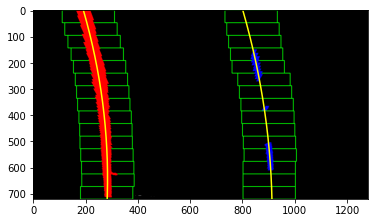

In [24]:
video1_output = 'videos_output/video1_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,1)
clip1 = VideoFileClip("project_video.mp4")
video1_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video1_clip.write_videofile(video1_output, audio=False)

In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video1_output))